*Benjamin Bradley*

**Date: July 16th, 2024**

Summary of past work:

- looking for trends in $w_t, w_r, w_p$ weight combos effects on reward & survival time
- observing consistent navigation to $r=1$ orbit from other orbits from $r=0.7$ to $r=1.3$

### Inits (Imports, Environment, Animation )
https://drive.google.com/drive/folders/1OUdtbpq4Cu2q3Dg3IOYcFQ3o8C9SSBww


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/UTRA/240711 BB/Trained model arrays"

import torch
import numpy as np

import gym
import itertools
import statsmodels.api as sm

import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

import os
import glob
import time
from datetime import datetime

import torch
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch as Arrow
from typing import Any, List, Sequence, Tuple

import math
import tensorflow as tf
from typing import Optional, Union

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

from IPython.display import HTML
from base64 import b64encode
from typing import Any, List, Sequence, Tuple

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1OUdtbpq4Cu2q3Dg3IOYcFQ3o8C9SSBww/240711 BB/Trained model arrays


In [ ]:
class PolarizeAction(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Convert polar thrust request to cartesian. Note that the
    cartesian thrust value will not rotate with the state during the simulation step.
    '''

    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap
        '''
        super().__init__(env)

    def action(self, action: np.ndarray) -> np.ndarray:
        '''
        Convert polar thrust requests to cartesian given the current position.

        action: 1D numpy array of shape (2,). The components corresponds to the radial
                and tangential components of the thrust respectively.

        Return:
            numpy array of shape (2,). The thrust in cartesian coordinates.
        '''
        state = self.unwrapped.state
        r, v = state[:2], state[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])

        return rotation_matrix @ action


class DiscretiseAction(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides 9 discrete thrust levels, no thrust, 4 cardinal directions, and 4 diagonal
    directions with unit length. Need to be combined with PolarizeAction to become polar.
    '''

    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''
        super().__init__(env)

        self.action_space = gym.spaces.Discrete(9)
        self.thrust_vectors = [
            [0, 0]] + [[np.cos(th), np.sin(th)] for th in np.linspace(0, 2 * np.pi, 8, endpoint=False)]

    def action(self, action: int) -> np.ndarray:
        '''
        Map integers to their correspnding thrust value.
        0 represents no thrust, 1-8 represents the other directions in counter-clockwise
        direction from the x-axis.

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        action = self.thrust_vectors[action]
        return np.ar
        ray(action)


class TangentialThrust(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides 3 discrete thrust vectors in the tangential direction
    with unit length. Note that it needs to be used in conjuction with PolarizeAction for
    the thrust values to point in the tangential direction.
    '''

    def __init__(self, env: gym.Env):
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''

        ### MY NOTES WILL HAVE TWO ## from now on because he also put some green comments now
        ## ?? the thrust had to be in polar coordinates for the thrust it's way more
        ## ?? convenient to have just one axis on which to put the thrust on !


        super().__init__(env)
        self.action_space = gym.spaces.Discrete(3)


        ### ?? Interesting, so the action in this version is decrete (to make it be continous I dont think that it should be too bad, that could be something that I could tryimplementing )
        ## For now from my understanding we just have the possibility of going clockwise, have no thrust or counter clockwise

        # For more detailed control
        # self.thrust_levels = [-1, -0.1, -.01, 0, 0.01, 0.1, 1] (I guess it's for now defined as 1 but we should see if it's too low or too high of an effect on it !)


    def action(self, action):

        '''
        Map integers to their correspnding thrust value.
        0: clockwise thrust
        1: no thrust
        2: counter-clockwise thrust

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        #print("Tangential action running ")
        return np.array([0, action - 1])

        # For more detailed control
        # return np.array([0, self.thrust_levels[action]])


class RadialThrust(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides 3 discrete thrust vectors in the radial direction
    with unit length. Need to be used in conjunction with PolarizeAction for the
    thrust values to point in the radial direction.ù
    '''

    ## ?? My question is with polarize Action is it point in etheta considering a polar coordinate system
    ## ?? centered on the mass or is it more to be considered as a Frenet coordinate system where it's just tengential to the motion of the spaceship?
    ## or is it a polar centered around the mass M.

    ## LOOKING BACK AT THE CODE FOR POLARIZE ACTION, it does indeed consider it with polar coordinates.


    def __init__(self, env: gym.Env):
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''
        super().__init__(env)

        self.action_space = gym.spaces.Discrete(3)

        # For more detailed control
        # self.thrust_levels = [-1, -0.3, -0.1, 0, 0.1, 0.3, 1]

    def action(self, action: int) -> np.ndarray:
        '''
        Map integers to their correspnding thrust value.
        0: thrust inwards
        1: no thrust
        2: thrust outwards

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        # For more detailed control
        # return np.array([self.thrust_levels[action], 0])

        ## ?? I don't understand at all what that represents the array represents why there is a -1 and why it's two values
        ## I actually do, this is in polar coordinates, it has the action that thrust here is declared to be 2 for thrust onward, 1 for no thrust and 0 for thrust inward
        ## which should be -1 etheta, 0 ethata and 1.

        ### A first suggestion of things to try is just having the action being what it's supposed to be doing, like -1, 0 or 1 not that.

        return np.array([action - 1, 0])


class PolarizeObservation(gym.ObservationWrapper):
    '''
    Wrapper for RocketEnv. Wraps state to provide radius, radial velocity, and tangential
    velocity.
    '''

    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap
        '''
        super().__init__(env)

    def observation(self, obs: np.ndarray) -> np.ndarray:
        '''
        Given the observation in cartesian coordinates, convert to polar observation.

        obs: numpy array with shape (4,). State vector with first 2 as cartesian position
                and last 2 as cartesian velocity

        Return
            numpy array with shape (3,) with radius, radial velocity, and tangential velocity,
            in that order.
        '''
        r, v = obs[:2], obs[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
        obs = np.array([dist, *(rotation_matrix @ v)])
        return obs


class RadialObservation(gym.ObservationWrapper):
    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap
        '''
        super().__init__(env)

    def observation(self, obs: np.ndarray) -> np.ndarray:
        '''
        Given the observation in cartesian coordinates, convert to observation with
        only radial position and velocity.

        obs: numpy array with shape (4,). State vector with first 2 as cartesian position
                and last 2 as cartesian velocity

        Return
            numpy array with shape (2,) with radius and radial velocity, in that order.
        '''
        r, v = obs[:2], obs[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        obs = np.array([dist, v @ rhat])
        return obs

class CTangentialThrust(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides continous ranges for thrust vectors in the tangential direction
    with unit length. Note that it needs to be used in conjuction with PolarizeAction for
    the thrust values to point in the tangential direction.
    '''

    def __init__(self, env: gym.Env):
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''
        super().__init__(env)
        self.action_space = gym.spaces.Box(low=-self.max_thrust, high= self.max_thrust, shape = (1,), dtype= np.float32)

    def action(self, action):
        '''
        Map integers to their correspnding thrust value.
        0: clockwise thrust
        1: no thrust
        2: counter-clockwise thrust

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        #print("It gets there ")
        action = np.array([0,action])
        #print(" the polar action should be :", action)
        state = self.unwrapped.state
        #print(" In order to verify manually : the current state is", state)
        r, v = state[:2], state[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
        action = rotation_matrix @ action
        #print(" The cartesian coordinate action is ", action)
        return action

from logging import raiseExceptions
from typing import (
    Any,
    Generic,
    Iterable,
    List,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    Type,
    TypeVar,
    Union,
    Dict,
    Callable
)

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym.spaces import Box
from gym.utils import seeding

#from animation import RocketAnimation


def make(name):
    '''
    Initialize Rocket Circularization environment. Contains the environment hyperparameters

    `RocketCircularization-v0` has wall mechanics on. When the craft hits the boundary, it will
    loose all orthogonal velocity towards the boundary.
    `RocketCircularization-v1` has wall mechanics off. When the craft hits the boundary, it will
    pass through boundary and mark the state as truncated.

    Usage:
    ```python
    env = make('RocketCircularization-v0')
    ```
    or in notebooks
    ```python
    with make('RocketCircularization-v0') as env:
        ...
    ```
    '''
    if name == 'RocketCircularization-v0':
        init_func = varied_l(r_min=0.5, r_max=1.5)
        return RocketEnv(max_step=400, simulation_step=1, rmax=1.5, rmin=0.5,
                         init_func=init_func, max_thrust=10,
                         oob_penalty=0, dt=0.01, wall_mechanics=False, clip_thrust='None',
                         velocity_penalty_rate=0.1, thrust_penalty_rate=0.001)
    if name == 'RocketCircularization-v1':
        return RocketEnv(max_step=1000, simulation_step=1, rmax=1.1, rmin=0.9, max_thrust=10,
                         oob_penalty=0, dt=0.01, wall_mechanics=False, clip_thrust='None',
                         velocity_penalty_rate=0.1, thrust_penalty_rate=0.001)
    else:
        raise ValueError(f'No environment {name}')


def uniform(r_min: float = 0.99, r_max: float = 1.01,
            rdot_min: float = -0.05, rdot_max: float = 0.05,
            thetadot_min: float = 0.99, thetadot_max: float = 1.01) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly under those
    conditions

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity
    thetadot_min: minimum bound for angular velocity
    thetadot_max: maximum bound for angular velocity

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max, thetadot_min, thetadot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = np.random.uniform(thetadot_min, thetadot_max)

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func


def varied_l(r_min: float = 0.9, r_max: float = 1.1,
             rdot_min: float = -0.5, rdot_max: float = 0.5,
             dl_min: float = -.5, dl_max: float = .5) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly with
    a range of angular momentum settings

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity
    dl_min: minimum deviation of angular momentum from target angular momentum
    dl_max: maximum deviation of angular momentum from target angular momentum

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max

        # r = np.random.uniform(r_min, r_max)
        # theta = np.random.uniform(0, 2 * np.pi)
        # rdot = np.random.uniform(rdot_min, rdot_max)
        # thetadot = (1 + np.random.uniform(dl_min, dl_max)) / r ** 2

        r = (r_min + r_max) / 2
        theta = 0
        rdot = 0
        thetadot = 0

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func


def target_l(r_min: float = 0.5, r_max: float = 1.5,
             rdot_min: float = -0.5, rdot_max: float = 0.5) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly
    with the target angular momentum

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = 1 / r ** 2

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func

def testing_1() -> Callable[[], List[np.float32]]:
  def func():
    r = 1
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1

    pos = [r, 0]
    vel = [rdot, r * thetadot]

    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func





def quadratic_penalty(state: np.ndarray, action: np.ndarray, r_target: float =1,
                      G: float = 1, M: float = 1) -> np.float32:
    '''
    Calculates the Quadratic reward at the current state with the current action. Subject to change.

    Current definition
    reward = w_r(r - rtarget)^2  + w_p(rtarget*vtangential_target - vtangential*r)^2 - w_T * |u|^2

    Arguments
    state: the current game state (x,y,vx,vy);
    action: actions performed to reach this state (F_tx, F_ty)
    rtarget: target radius of the craft (1)
    w-rm, w_p, w_t : the weights respective of each difference in the quadratic function

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
      A scalar that has as a goal to converge to 0 with training
    '''
    vtarget = np.sqrt(G * M / r_target)
    r, v = state[:2], state[2:]
    dist = np.linalg.norm(r)
    rhat = r / dist
    rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
    vpolar = rotation_matrix @ v
    #print("Action in quadratic ",action)
    #print("dist:", dist - r_target, " angular momentum:", vpolar[1]*dist -vtarget*r_target, "action",np.linalg.norm(action))
    quadratic = abs(dist - r_target) + 2*abs(vpolar[1]*dist -vtarget*r_target) + 0.2*abs(np.linalg.norm(action))

    #w_t*np.linalg.norm(action)**2
    #print(quadratic)
    return quadratic

def reward_function(state: np.ndarray, action: np.ndarray, rtarget: float,
                    min :float = 0, max :float = 4, G: float = 1, M: float = 1) -> np.float32:
    '''
    Calculates the reward at the current state with the current action. Subject to change.

    state: the current game state
    action: actions performed to reach this state
    rtarget: target radius of the craft
    velocity_penalty_rate: ratio of velocity penalty to radius penalty
    thrust_penalty_rate: ratio of thrust penalty to radius penalty
    mode: Mode of rewards, one of 'Quadratic' or 'Gaussian'
            Quadratic: -(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2) - thrust_penalty * |u|^2
            Gaussian: exp(-(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2) - thrust_penalty * |u|^2)

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
        Reward in this state
    '''
    value = quadratic_penalty(state, action, rtarget, G, M)

    return np.clip(-np.log(value),min,max)


def score(state: np.ndarray, rtarget: float,  velocity_penalty_rate: float,
          G: float = 1, M: float = 1) -> np.float32:
    '''
    DEPRECATED
    Calculates the reward at the current state without action penalty. Subject to change.
    This may be used for a differential reward structure

    score = -(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2)

    state: the current game state
    rtarget: target radius of the craft
    velocity_penalty_rate: ratio of velocity penalty to radius penalty

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
        Score in this state
    '''
    vtarget = np.sqrt(G * M / rtarget)
    r, v = state[:2], state[2:]
    dist = np.linalg.norm(r)
    rhat = r / dist
    rotation_matrix = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
    vtarget = rotation_matrix @ np.array([0, vtarget])

    return -np.abs(dist - rtarget) - velocity_penalty_rate * np.sum(np.abs(v - vtarget))


def clip_by_norm(t: np.ndarray, mins: float, maxs: float) -> np.ndarray:
    '''
    Clip the vector by its l2 norm between an interval.

    t: the vector to clip
    mins: the minimum norm
    maxs: the maximum norm

    Return:
        Clipped vector

    Raises:
        ValueError: when norm of input vector is zero and minimum is not zero
    '''
    norm = np.linalg.norm(t)
    if np.count_nonzero(t) == 0 and mins > 0:
        raise ValueError('Trying to clip norm of zero vector')
    if norm < mins:
        t = t * mins / norm
    elif norm > maxs:
        t = t * maxs / norm

    return t


def wall_clip_velocity(v: np.ndarray, r: np.ndarray, mins: float, maxs: float):
    '''
    If the particle is moving towards the circular boundaries, cancel velocity perpendicular to the boundary

    v: velocity vector
    r: position vector
    mins: minimum radius
    maxs: maximum radius

    Return:
        Velocity vector modified by the walls
    '''
    # Obtain the velocity component orthogonal to the circular boundaries
    direction = v @ r
    along = (v @ r) / (r @ r) * r
    ortho = v - along

    # Get the distance from origin to test if the object is at the bounds
    dist = np.linalg.norm(r)

    # If there is a component facing in at minimum radius
    if dist < mins and direction < 0:
        return ortho
    # If there is a component facing out at maximum radius
    elif dist > maxs and direction > 0:
        return ortho
    else:
        return v


class RocketEnv(gym.Env):
    '''
    Open AI Gym environment for Rocket Circularization
    '''

    def __init__(self,
                 G: float = 1, M: float = 1, m: float = .01, dt: float = .01,
                 rmin: float = .1, rmax: float = 2, rtarget: float = 1, vmax: float = 10,
                 init_func: Callable[[], np.ndarray] = varied_l(), wall_mechanics: bool = True,
                 oob_penalty: float = 10, max_thrust: float = 10, clip_thrust: str = 'Ball',
                 velocity_penalty_rate: float = .001, thrust_penalty_rate: float = .0001,
                 max_step: int = 500, simulation_step: int = 1) -> None:
        '''
        Initializes the environment

        G: Gravitational Constant, default 1
        M: Mass of center object, default 1
        m: Mass of orbiting object, default .01
        dt: Simulation time step, default .01

        rmin: game space radius lower bound, default .1
        rmax: game space radius upper bound, default 2
        rtarget: the target radius the craft is supposed to reach, default 1
        vmax: maximum velocity allowed in the game space (implemented for simulation accuracy and network interpolation), default 10
        oob_penalty: penalty for being out of bounds, default 10
        init_func: function that returns an initial condition, default varied_l()
        wall_mechanics: whether the boundary acts as a wall.
                If true, all normal velocity towards the boundary will be canceled upon impact
                If false, the craft will pass through the wall and truncation will be marked true

        max_thrust: The magnitude of the thrust, scales the action u
        clip_thrust: The way in which the action is clipped, Options: Box, Ball, None, default: Ball

        velocity_penalty_rate: the penalty of velocity as a ratio of radius penalty
        thrust_penalty_rate: the penalty of thrust as a ratio of radius penalty

        max_step: number of iterations in each episode if no early-termination is encountered, default: 500
        simulation_step: number of simulation steps for every game step. Reducing timestep and increasing simulation step
                increases simulation accuracy, but may be more computationally straining
        '''
        super().__init__()

        #print("It is my environment that is running")
        self.observation_space = Box(low=np.array([-rmax, -rmax, -vmax, -vmax]),
                                     high=np.array([rmax, rmax, vmax, vmax]),
                                     shape=(4, ), dtype=np.float32)
        self.action_space = Box(low=np.array([-max_thrust, -max_thrust]),
                                high=np.array([max_thrust, max_thrust]),
                                shape=(2, ), dtype=np.float32)

        self.G, self.M, self.m, self.dt = G, M, m, dt
        self.rmin, self.rmax, self.rtarget = rmin, rmax, rtarget
        self.vmax = vmax
        self.oob_penalty = oob_penalty
        self.max_thrust = max_thrust
        self.clip_thrust = clip_thrust
        self.init_func = init_func
        self.wall_mechanics = wall_mechanics
        self.velocity_penalty_rate = velocity_penalty_rate
        self.thrust_penalty_rate = thrust_penalty_rate

        self.max_step, self.simulation_step = max_step, simulation_step
        self.iters = 0

        # Animation object
        lim = rmax * 1.1
        self.animation = RocketAnimation(r_min=rmin, r_target=rtarget, r_max=rmax, xlim=(-lim, lim), ylim=(-lim, lim),
                                         markersize=10, circle_alpha=1, t_vec_len=.1)

    def reset(self, seed: Optional[int] = None,
              return_info: bool = False,
              options: Optional[dict] = None) -> Union[np.ndarray, Tuple[np.ndarray, dict]]:
        '''
        Resets the environment with a new state, return the new state as well as information
        if required.

        seed: NOT IMPLEMENTED, randomizer seed
        return_info: If information is returned
        options: some options for initialization
                init_func: the function used to initialize the state, provided uniform, target_l, varied_l

        Return:
            the initial state, shape (4,)
        '''
        # super().reset(seed=seed)

        if options is not None and 'init_func' in options:
            init_func = options['init_func']
        else:
            init_func = self.init_func

        self.state = np.array(init_func())
        self.init_state = self.state
        self.iters = 0
        self.prev_score = - \
            np.abs(self.rmax - self.rtarget) - \
            self.velocity_penalty_rate * 2 * self.vmax
        self.done = False
        self.last_action = np.array([0, 0])

        lim = self.rmax * 1.1
        self.animation = RocketAnimation(r_min=self.rmin, r_target=self.rtarget, r_max=self.rmax,
                                         xlim=(-lim, lim), ylim=(-lim, lim),
                                         markersize=10, circle_alpha=1, t_vec_len=.1)

        if return_info:
            return self.state, dict()
        else:
            return self.state

    def step(self, action: np.ndarray) -> Union[Tuple[np.ndarray, float, bool, bool, dict],
                                                Tuple[np.ndarray, float, bool, dict]]:
        '''
        Accept action and modify the states accordingly.

        action: an array with shape (2,) representing the thrust component in the 2 cartesian directions.

        Return:
            state, shape (2,),
            reward from this state,
            if the game is done running,
            if the agent is out-of-bounds, and
            some more info about the game
        '''
        if self.done:
            print('Warning: Stepping after done is True')

        # Clipp action if needed
        action = np.array(action)
        if self.clip_thrust == 'Box':
            action = np.clip(action, -1, 1)
        elif self.clip_thrust == 'Ball':
            magnitude = np.linalg.norm(action)
            if magnitude > 1:
                action = action / magnitude
        elif self.clip_thrust == 'None':
            pass
        else:
            raise ValueError(
                f'Thrust clipping mode {self.clip_thrust} does not exist')

        # For easy access from wrappers
        self.last_action = action

        r, v = self.state[:2], self.state[2:]
        reward = 0
        info = dict()

        # Simulate for a number of steps
        for _ in range(self.simulation_step):
            # Calculate total force
            gravitational_force = - (self.G * self.M * self.m) / \
                (np.power(np.linalg.norm(r), 3)) * r  # F = - GMm/|r|^3 * r
            thrust_force = action * self.m * self.max_thrust
            total_force = gravitational_force + thrust_force
            # Update position and location, this can somehow guarantee energy conservation
            # If the craft hits a wall, all normal velocity cancels
            v = v + total_force / self.m * self.dt
            # v = clip_by_norm(v, 0, self.vmax)
            r = r + v * self.dt
            if self.wall_mechanics:
                v = wall_clip_velocity(v, r, self.rmin, self.rmax)
                r = clip_by_norm(r, self.rmin, self.rmax)
            # Scored-based reward structure
            reward += reward_function(np.array([*r, *v]), action, self.rtarget)
            # Differential-score-based Reward structure
            # step_reward, self.prev_score = reward_function(np.array([*r, *v]), action, self.prev_score, self.rtarget, self.velocity_penalty_rate,
            #                                                self.thrust_penalty_rate, self.G, self.M)
            # reward += step_reward * self.dt

            # If out-of-bounds, end the game
            if self.wall_mechanics:
                # The game will not be truncated when wall-mechanics are disabled
                truncated = False
            else:
                # This condition may be changed into a controllability condition
                if np.linalg.norm(r) > self.rmax or np.linalg.norm(r) < self.rmin:
                    reward -= self.oob_penalty
                    truncated = True
                    # self.state = self.init_state
                else:
                    self.state = np.array([*r, *v])
                    truncated = False

        self.state = np.array([*r, *v])
        self.iters += 1

        if self.iters >= self.max_step:
            self.done = True

        return self.state, reward, self.done, truncated, info

    def render(self, *args: Tuple[Any], **kwargs: Dict[str, Any]) -> None:
        '''
        Record frames of the animation. Need to be used in conjunction with the
        show() method.
        '''
        self.animation.render(self.state, self.last_action, self.last_action,
                              self.rmin, self.rtarget, self.rmax)

    def show(self, path: Optional[str] = None, summary: bool = False) -> None:
        '''
        Show the saved frames of the animation or produce a summary

        path: if the animation is saved, the path to which it is saved. If None, the
                animation is shown in a pop-up window. Note that pop-up window
                animation does not work in notebooks, and need to be closed for
                the execution to continue. default, None
        summary: if animation is not saved, if to produce a summary plot of the game
                episode instead.
        '''
        if path is None:
            path = "path.mp4"
        self.animation.save_animation(path)
        self.animation.summary_plot()
        return path

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# matplotlib.use('TkAgg')
plt.style.use('seaborn-pastel')


class RocketAnimation(object):
    def __init__(self, r_min=0.1, r_target=1, r_max=10, xlim=(-10.2, 10.2), ylim=(-10.2, 10.2), markersize=10, circle_alpha=1, t_vec_len=1):
        '''
        Initialize Animation Object

        Parameters:
            r_min: the minimum radius circle
            r_target: the target radius circle
            r_max: the maximum radius circle
            x_lim: tuple of 2 elements, max and min bound of the axes on the x direction
            y_lim: tuple of 2 elements, max and min bound of the axes on the y direction
            markersize: int, the size of the marker indicating rocket
            t_vec_len: the scale of the thrust vector
        '''

        self.r_min = r_min
        self.r_target = r_target
        self.r_max = r_max

        self.marker_size = markersize
        self.circle_alpha = circle_alpha
        self.t_vec_len = t_vec_len

        self.states = list()
        self.thrusts = list()
        # Note : I am not using requested_thrust for now, but I let it because I think it could be interesting
        self.requested_thrusts = list()
        self.theta_dot = list()

        #plots to verify the behavior of the actor critic
        self.rewards = list()
        self.action = list()

        # Wait why on earth is that a list ??
        self.rmin = list()
        self.rtarget = list()
        self.rmax = list()

        self.xlim = xlim
        self.ylim = ylim


    #No changes are made to this function
    def _circle(self, radius):
        '''
        Create data for a circle with a certain radius

        Parameters:
            radius: the radius of the circle

        Return:
            tuple of np.ndarray representing the coordinates of each point
            on the circle
        '''
        theta = np.linspace(0, 2 * np.pi, 100)
        x, y = radius * np.cos(theta), radius * np.sin(theta)
        return x, y

    def _init(self,):
        '''
        Function used for generating the animation
        The first step in the animation

        Returns:
            line to update
        '''
        #Only initiating the main line to update

        # this is necesssary because for some reasons it is called 3 times
        self.ax.clear()

        self.arrow = Arrow(posA=(0, 0), posB=(0, 0), arrowstyle='simple', mutation_scale=5, color='r')
        self.ax.add_patch(self.arrow)
        self.line, = self.ax.plot([], [], marker='o', markersize=self.marker_size, alpha=self.circle_alpha)
        self.min_circle, = self.ax.plot(*self._circle(self.r_min), '--', label='Minimum Radius')
        self.start_circle, = self.ax.plot(*self._circle(1.1), '--', label='Starting Orbit', color='tab:orange') ##### TARGET = 1.1
        self.target_circle, = self.ax.plot(*self._circle(self.r_target), '--', label='Target Orbit')
        self.max_circle, = self.ax.plot(*self._circle(self.r_max), '--', label='Maximum Radius')
        self.ax.grid(True)
        self.ax.legend(loc='upper left')
        return self.line, self.min_circle, self.target_circle, self.max_circle


    def _animate(self, i):
        '''
        Function used for generating the animation
        The update function run each time the animation advances

        Parameters:
            i: the number of frames of the animation

        Returns:
            line to update
        '''
        st = self.states[i]
        vec = self.thrusts[i] * self.t_vec_len * (self.xlim[1] - self.xlim[0])

        self.line.set_data([st[0]], [st[1]])
        self.min_circle.set_data(*self._circle(self.rmin[i]))
        self.target_circle.set_data(*self._circle(self.rtarget[i]))
        self.max_circle.set_data(*self._circle(self.rmax[i]))

        self.arrow.set_positions(posA=st[:2], posB=st[:2] + vec)
        self.fig.suptitle(f'Iteration: {i}')
        return self.line, self.min_circle, self.target_circle, self.max_circle

    ## DEFINING A NEW ANIMATION FUNCTION TO ONLY HAVE SUMMARY AND THE LITTLE VIDEO

    def save_animation(self, name):
        '''
        Save the animation in a file

        Parameter:
            name: str, the file name
        '''
        print('save animation is called')

        self._transform_vectors()
        self.fig = plt.figure(figsize=(10, 10), num=1,
                              clear=True, tight_layout=True)
        print("figure instantiated ")
        self.ax = self.fig.add_subplot(111)
        anim = FuncAnimation(self.fig, self._animate, init_func=self._init, frames=len(
            self.states), blit=True, interval=100, repeat=False)
        anim.save(name, dpi=80)

    def _plot_thrust_magnitude(self, ax):
        print("plot thrust magnitude is called ")
        ax.set_title('Thrust Magnitude')
        ax.plot(self.thrusts_norm, label='thrust magnitude')
        ax.plot(self.requested_thrusts_norm,
                    label='requested thrust magnitude')
        ax.grid(True)
        ax.legend()

## CHANGED
    def _plot_thrust_value(self, ax):
        ax.set_title('Thrust Values')
        ax.plot([thrust[1]
                     for thrust in self.thrusts_polar], label='thrust tangent')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_direction(self, ax):
        ax.set_title('Thrust Direction (Angle from $\hat{r}$)')
        ax.plot(self.thrust_direction, label='Thrust Direction')
        ax.plot(self.requested_thrust_direction,
                label='Requested Thrust Direction')
        ax.grid(True)
        ax.legend()

    def _plot_radius(self, ax):
        ax.set_title('Radius')
        ax.plot(self.rs, label='radius')
        ax.grid(True)
        ax.legend()

    def _plot_velocities(self, ax):
        ax.set_title('Velocities')
        ax.plot([vel[0] for vel in self.vel_polar], label='radial velocity')
        ax.plot([vel[1] for vel in self.vel_polar],
                label='tangential velocity')
        ax.grid(True)
        ax.legend()

## ADDED

    def _plot_theta_dot(self, ax):
      ax.set_title('theta_dot')
      ax.plot([theta for theta in self.theta_dot])
      ax.grid(True)

    def summary_plot(self):
        self._transform_vectors()
        print("It is creating a figure 1 ")
        self.fig1 = plt.figure(figsize=(10, 5), num=1,
                              clear=True, tight_layout=True)
        ax1 = self.fig1.add_subplot(221)
        ax2 = self.fig1.add_subplot(222)
        ax3 = self.fig1.add_subplot(223)
        ax4 = self.fig1.add_subplot(224)

        self.fig1.suptitle('Run Summary')


        self._plot_thrust_value(ax1)
        self._plot_theta_dot(ax2)
        self._plot_radius(ax3)
        self._plot_velocities(ax4)

        self.fig1.tight_layout()

        return self.fig1

    def show(self, name):
      # saving the animation
      self.save_animation(name)
      #creating a summary
      self.summary_plot()


    def _get_transforms(self, states):
        # So basically transforms is the list of all the rotation matrices
        transforms = list()
        rs = list()
        thetas = list()

        for st in states:
            # position and velocity in cartesian coordinates
            pos, vel = st[:2], st[2:]
            # norm of the position (s)
            r = np.linalg.norm(pos)
            #getting theta
            theta = np.arctan2(pos[1], pos[0])
            # rhat in cartesian
            rhat = pos / r

            rot_mat = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
            transforms.append(rot_mat)
            # all the radius
            rs.append(r)
            #all the angle it has been at
            thetas.append(theta)

        return transforms, rs, thetas

    def _forward_transform(self, transforms, vecs):
        return [tr @ vec for tr, vec in zip(transforms, vecs)]

    # it can get the vector in its original position technically if vec = T@vec
    def _inverse_transform(self, transforms, vecs):
        return [tr.T @ vec for tr, vec in zip(transforms, vecs)]


    def _transform_vectors(self, ):
        #tranforms : rot matrix, rs : the radius, thetas : the angles
        transforms, self.rs, self.thetas = self._get_transforms(self.states)

        #gets the polar velocities
        self.vel_polar = self._inverse_transform(
            transforms, [st[2:] for st in self.states])

        # it's the last action in cartesian coordinate
        self.thrusts_polar = self._inverse_transform(transforms, self.thrusts)

        #This for now is still defined as the last action in cartesian coordinates (but could be interesting to implement)
        self.requested_thrusts_polar = self._inverse_transform(
            transforms, self.requested_thrusts)

        # ADDING THIS
        self.theta_dot = [v_tangential / r if r != 0 else 0 for v_tangential, r in zip([vel[1] for vel in self.vel_polar], self.rs)]

        ## CHANGE HERE : WE HAVE THE THRUST IN POLAR, NO NEED FOR THE NORM (THOSE FOUR UNECESSARY)
        self.thrusts_norm = [np.linalg.norm(thrust) for thrust in self.thrusts]
        self.requested_thrusts_norm = [np.linalg.norm(
            thrust) for thrust in self.requested_thrusts]
        self.thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.thrusts_polar]
        self.requested_thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.requested_thrusts_polar]

      ## MAYBE ADD THETA DOT

    def render(self, state, thrust, requested_thrust, rmin, rtarget, rmax):
        '''
        Records the current state in the animation for future rendering

        Parameters:
            state: the current state to render
        '''
        # I DON'T UNDERDSTAND THE POINT OF HAVING AN R_MIN AND R_MAX DEFINED LIKE THAT !!
        self.states.append(state)
        self.thrusts.append(thrust)
        self.requested_thrusts.append(requested_thrust)
        self.rmin.append(rmin)
        self.rtarget.append(rtarget)
        self.rmax.append(rmax)
        #print("array of thrust", self.thrusts, "current thrust", thrust)

    def return_arrays(self):
      return self.states, self.thrusts


if __name__ == '__main__':
    pass


<>:149: DeprecationWarning: invalid escape sequence '\h'
<ipython-input-4-4dd734fa6e60>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [ ]:
def moving_average(data, window_size):
    """Calculate the moving average of the given list."""
    i = 0
    moving_averages = []

    while i < len(data) - window_size + 1:
        window_average = round(np.sum(data[
          i:i+window_size]) / window_size, 2)
        moving_averages.append(window_average)
        i += 1

    return moving_averages

def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("============================================================================================")
device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")


################################## PPO Policy ##################################
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]

# It's very similar to the initial actor critic class implemented above

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        #In this section I'm only interested in the continous space
        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        #I'm mainly going to keep the same dimensions as the ones used above
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, action_dim),
                            nn.Tanh()
                        )
            #the use of tanh here maps the actions in the range -1 / 1.
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.Tanh(),
                            nn.Linear(12, action_dim),
                            nn.Softmax(dim=-1)
                        )
            # the use of softmax if it's not continous gives for each action, a probability associated.
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 1)
                    )
        # The use of tanh as an activation function here prevents a gradient
        #explosion by keeping in between the layers the values between -1/1


    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    # This function is used during the interaction phase, where the agent interacts with the environment to collect experiences.
    def act(self, state, min, max):
        # the continous action
        if self.has_continuous_action_space:
          #so the actor has as a purpose to give off the meand of the action explaining even more the use of tanh
            action_mean = self.actor(state)
            # so that's where we aff the varience to it
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            # This creqtes the multivavariate normal distribution with the specified mean and cov_mat
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        # It samples from the distribution the action
        action = dist.sample()
        #print("action before clamp",action)
        #action = torch.clip(action,min,max) #ensures that the action is between a specific range.
        #print("action after clamp", action)
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()

  # This function is used during the training phase
    def evaluate(self, state, action):

        if self.has_continuous_action_space:

            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # For Single Action Environments.(which is our situation here)
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space=True, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma # discount factor
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.buffer = RolloutBuffer()
        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ]) #specific learning rate for the actor and for the critic

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device) #I'm wondering if this line is actually necessary
        self.policy_old.load_state_dict(self.policy.state_dict()) # apparently that copies the weights of the policy dict so that it starts at the same point, before any update is being made.

        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

#we decay the standard deviation in order to have a more norrow down possible actions to take so more exploitation and less exploration.
    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")
        print("--------------------------------------------------------------------------------------------")

    def select_action(self, state, min , max):
        #print("It's getting there")
        if self.has_continuous_action_space:
            with torch.no_grad():
                #print("before state")
                state = torch.FloatTensor(state).to(device)
                #print("before policy_old.act")
                action, action_logprob, state_val = self.policy_old.act(state, min, max)
                #print("action in select_action", action)# so it's the old policy that acts. Because it's the previous policy that has been updated from the previous update but hasn't acted yet
            #print("action ",action, " action_logprob ", action_logprob, " state_val ",state_val)
            #print("the buffer will get updated")
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)
            #print("the buffer got updated")

            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0  # wait why is it 0 though ?
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)): #This is basically doing with a for loop what my discount function was doing
            if is_terminal: # finish
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            state_values = torch.squeeze(state_values)                                   # match state_values tensor dimensions with rewards tensor
            ratios = torch.exp(logprobs - old_logprobs.detach())                                     # Finding the ratio (pi_theta / pi_theta__old)
            surr1 = ratios * advantages                                                                                    # Finding Surrogate Loss
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy # final loss of clipped objective PPO
            self.optimizer.zero_grad()                                                                                         # take gradient step
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        # clear buffer
        self.buffer.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))


Device set to : cpu


## Searching through $w_t, w_r, w_p$ space

In [ ]:
weights = [0.01, 0.1, 1, 10]
combos = []

for w1 in weights:
  for w2 in weights:
    for w3 in weights:
      combo = [w1, w2, w3]
      combos.append(combo)

combos = np.array(combos)
r_slopes = np.array([43.96563729800803, 20.216414982061675, 12.784971856284447, 27.172248190184387, 22.11113133159205, 30.14696886968397, 16.945495503856844, 10.138459064026083, 24.177999066961597, 13.584356162389174, 35.277862971769956, 11.168442916923855, 16.312495035276843, 8.280989879203684, 14.23915820512033, 10.469763983834547, 27.314219594575732, 19.49390543259154, 31.97040141475337, 19.751662739325653, 14.926938719346513, 27.80623215911648, 17.49607839892258, 7.262140913927501, 10.467271015786913, 13.282877422245356, 21.49718739426125, 8.654532090131012, 14.330620703356372, 19.16281740384146, 18.175546602958736, 5.6238756735863795, 18.02175866057859, 17.364091281440164, 9.17629995207232, 6.23408337397081, 13.48406119267314, 26.623295788735824, 10.823132420037744, 7.198323088212492, 18.146258108929125, 13.118479839164362, 8.589805011144348, 6.430106608841698, 10.211284229800857, 3.8054731358263156, 8.822159813591014, 10.093472451889719, 4.921408385663831, 1.7709887515133846, 3.534490304983047, 3.2865030562426614, 2.079800561811882, 1.2142798487912465, 1.2532963867728073, 2.3400571787237285, 1.6944368201445086, 2.713049169701753, 0.9823215594336145, 0.8657947564504488, 5.491499223730647, 2.348456647805051, 1.7148913865345636, 1.3232246926411295])
l_slopes = np.array([10.995476873914871, 5.095668441271057, 4.496412673569913, 11.609082895867225, 5.6612152438285674, 7.833016018791355, 5.2426122705082765, 5.723537161798454, 8.21211324154188, 4.468302296705416, 13.106560486584698, 5.627678477671627, 10.281758478973797, 4.514969713236671, 7.565867701267665, 7.587999823052347, 7.58913327259864, 5.629874613959784, 10.673558252402177, 9.981130677178431, 4.325988139065954, 8.580474096454916, 6.98601720421069, 4.436636632832037, 3.643619062501308, 7.483735939547106, 9.490557685730916, 6.2985505326090285, 9.257581051826245, 10.328459877952582, 13.0147333938697, 6.121088123857576, 8.878644190036942, 9.296655075227413, 5.459985710032058, 6.32264032894032, 7.445855391682972, 15.396798913534184, 8.3190174256739, 6.818452627420518, 11.394441959058145, 8.637661285246889, 7.120387719965644, 7.215464013511698, 9.151367005781493, 4.369874570445683, 8.809808183532912, 9.203449544964036, 11.518828280343559, 5.129725626832896, 9.580818423778439, 10.508911051159103, 5.246228963656632, 3.550179234881348, 3.5340277722457443, 9.500671506574356, 6.154961260039726, 8.822816386751448, 3.53353149949647, 3.5558695086293004, 18.525537124206746, 8.795518313812018, 7.263337113120725, 6.617102138773783])

######### Rewards Scatter #########
scatter = go.Scatter3d(
    x=combos[:, 0],
    y=combos[:, 1],
    z=combos[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=r_slopes,
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(
                title='Value',
                tickvals=r_slopes[::10],
                ticktext=[str(round(val, 3)) for val in r_slopes[::10]],
                len=0.75)))

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='w_t', type='log'),
        yaxis=dict(title='w_r', type='log'),
        zaxis=dict(title='w_p', type='log')),
    title='Plot of Weight Combos to Slope of increase in Reward averaged over 5 runs'
)

fig = go.Figure(data=[scatter], layout=layout)
pio.show(fig)

######### Lengths Scatter #########
scatter = go.Scatter3d(
    x=combos[:, 0],
    y=combos[:, 1],
    z=combos[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=l_slopes,
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(
                title='Value',
                tickvals=l_slopes[::6],
                ticktext=[str(round(val, 3)) for val in l_slopes[::6]],
                len=0.75)))

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='w_t', type='log'),
        yaxis=dict(title='w_r', type='log'),
        zaxis=dict(title='w_p', type='log')),
    title='Plot of Weight Combos to Slope of increase in Length averaged over 5 runs'
)

fig = go.Figure(data=[scatter], layout=layout)
pio.show(fig)

### Default Env

In [ ]:
from logging import raiseExceptions
from typing import (
    Any,
    Generic,
    Iterable,
    List,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    Type,
    TypeVar,
    Union,
    Dict,
    Callable
)

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym.spaces import Box
from gym.utils import seeding

## I deleted from animation in order ton use the animation I have in the notebook
## Adding a continous episode option
def make(name):
    '''
    Initialize Rocket Circularization environment. Contains the environment hyperparameters

    `RocketCircularization-v0` has wall mechanics on. When the craft hits the boundary, it will
    loose all orthogonal velocity towards the boundary.
    `RocketCircularization-v1` has wall mechanics off. When the craft hits the boundary, it will
    pass through boundary and mark the state as truncated.

    Usage:
    ```python
    env = make('RocketCircularization-v0')
    ```
    or in notebooks
    ```python
    with make('RocketCircularization-v0') as env:
        ...
    ```
    '''
    if name == 'RocketCircularization-v0':
        init_func = varied_l(r_min=0.5, r_max=1.5)
        return RocketEnv(max_step=400, simulation_step=3, rmax=1.5, rmin=0.5,
                         init_func=init_func, max_thrust=.1,
                         oob_penalty=0, dt=0.03, wall_mechanics=True,
                         velocity_penalty_rate=0.1, thrust_penalty_rate=0.001)


    else:
        raise ValueError(f'No environment {name}')


def uniform(r_min: float = 0.99, r_max: float = 1.01,
            rdot_min: float = -0.05, rdot_max: float = 0.05,
            thetadot_min: float = 0.99, thetadot_max: float = 1.01) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly under those
    conditions

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity
    thetadot_min: minimum bound for angular velocity
    thetadot_max: maximum bound for angular velocity

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max, thetadot_min, thetadot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = np.random.uniform(thetadot_min, thetadot_max)

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func


def varied_l(r_min: float = 0.9, r_max: float = 1.1,
             rdot_min: float = -0.5, rdot_max: float = 0.5,
             dl_min: float = -.5, dl_max: float = .5) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly with
    a range of angular momentum settings

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity
    dl_min: minimum deviation of angular momentum from target angular momentum
    dl_max: maximum deviation of angular momentum from target angular momentum

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = (1 + np.random.uniform(dl_min, dl_max)) / r ** 2

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
        #print("reset positon", pos)
        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func


def target_l(r_min: float = 0.5, r_max: float = 1.5,
             rdot_min: float = -0.5, rdot_max: float = 0.5) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly
    with the target angular momentum

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = 1 / r ** 2

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func

def testing_1() -> Callable[[], List[np.float32]]:
  def func():
    r = 1
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1

    pos = [r, 0]
    vel = [rdot, r * thetadot]

    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

def orbit1_1() -> Callable[[], List[np.float32]]:
  def func():
    r = 1.1
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 0.9535

    pos = [r, 0]
    vel = [rdot, r * thetadot]

    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])

    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func


# FIRST MODIFICATION : CHANGE OF THE QUADRATIC PENALTY

def quadratic_penalty(state: np.ndarray, action: np.ndarray, r_target: float =1,
                      w_r: float=1, w_p :float =1,w_t :float =0.5,
                      G: float = 1, M: float = 1,mode: str = 'abs') -> np.float32:
    '''
    Calculates the Quadratic reward at the current state with the current action. Subject to change.

    Current definition
    reward = w_r(r - rtarget)^2  + w_p(rtarget*vtangential_target - vtangential*r)^2 - w_T * |u|^2

    Arguments
    state: the current game state (x,y,vx,vy);
    action: actions performed to reach this state (F_tx, F_ty)
    rtarget: target radius of the craft (1)
    w-rm, w_p, w_t : the weights respective of each difference in the quadratic function

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
      A scalar that has as a goal to converge to 0 with training
    '''
    vtarget = np.sqrt(G * M / r_target)
    r, v = state[:2], state[2:]
    dist = np.linalg.norm(r)
    rhat = r / dist
    rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
    vpolar = rotation_matrix @ v
    #print("Action in quadratic ",action)
    #print("dist:", dist - r_target, " angular momentum:", vpolar[1]*dist -vtarget*r_target, "action",np.linalg.norm(action))
    if mode == 'squared' :
      quadratic = w_r*(dist - r_target)**2 + w_p*(vpolar[1]*dist -vtarget*r_target)**2 + w_t*(np.linalg.norm(action))**2
    elif mode == 'abs' :
      quadratic = w_r*abs(dist - r_target) + w_p*abs(vpolar[1]*dist -vtarget*r_target) + w_t*abs(np.linalg.norm(action))

    #w_t*np.linalg.norm(action)**2
    #print(quadratic)
    return quadratic


# SAME HERE (type of reward function ?)
def clip_by_norm(t: np.ndarray, mins: float, maxs: float) -> np.ndarray:
    '''
    Clip the vector by its l2 norm between an interval.

    t: the vector to clip
    mins: the minimum norm
    maxs: the maximum norm

    Return:
        Clipped vector

    Raises:
        ValueError: when norm of input vector is zero and minimum is not zero
    '''
    norm = np.linalg.norm(t)
    if np.count_nonzero(t) == 0 and mins > 0:
        raise ValueError('Trying to clip norm of zero vector')
    if norm < mins:
        t = t * mins / norm
    elif norm > maxs:
        t = t * maxs / norm

    return t

# MODIFICATION : The quadratic function is wrapped by a -log, in order to maximize the reward
# when converging to 0 with an option to clip the reward function especially when the vlaue of the quadratic
# converges to 0

def reward_function(state: np.ndarray, action: np.ndarray, rtarget: float,
                    w_r: float=1, w_p :float =1,w_t :float =1,
                    mode: str = 'Log_10', min :float = 0, max :float = 4, G: float = 1, M: float = 1) -> np.float32:
    '''
    Calculates the reward at the current state with the current action. Subject to change.

    state: the current game state
    action: actions performed to reach this state
    rtarget: target radius of the craft
    velocity_penalty_rate: ratio of velocity penalty to radius penalty
    thrust_penalty_rate: ratio of thrust penalty to radius penalty
    mode: Mode of rewards, one of 'Quadratic' or 'Gaussian'
            Quadratic: -(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2) - thrust_penalty * |u|^2
            Gaussian: exp(-(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2) - thrust_penalty * |u|^2)

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
        Reward in this state
    '''
    value = quadratic_penalty(state, action, rtarget,w_r,w_p,w_t, G, M)

    if mode == 'Quadratic':
        return value
    elif mode == 'Log_10':
        #print(np.clip(-np.log10(value),min,max))
        return np.clip(-np.log10(value),min,max)
    elif mode == 'Ln' :
        return np.clip(-np.log(value),min,max)
    elif mode ==  'Inverse' :
        return np.clip(1/(value), min, max)
    else:
        ValueError(f'Invalid reward mode {mode}')

## THAT IS SOMETHING ELSE TO THINK ABOUT IF COMING BACK TO CONTINOUS EPISODES
## MY THOUGHT IS THAT INSTEAD OF REACHING A BOUND, HAVE A 0 REWARD AND START BACK LIKE REINTIALIZE
## SO CAN STILL BE SEEN AS EPISODES

class RocketEnv(gym.Env):
    '''
    Open AI Gym environment for Rocket Circularization
    '''

    # Getting rid of the wall mechanics
    # rmin and rmax will be used as bounds

    def __init__(self,
                 G: float = 1, M: float = 1, m: float = .01, dt: float = .01,
                 rmin: float = .1, rmax: float = 2, rtarget: float = 1, vmax: float = 10,
                 w_r:float = 1, w_p:float =1, w_t: float=1, mode: str = 'Log_10',
                 init_func: Callable[[], np.ndarray] = varied_l(),
                 oob_penalty: float = 10, max_thrust: float = .1, clip_thrust: str = 'Ball',
                 max_step: int = 500, simulation_step: int = 1) -> None:
        '''
        Initializes the environment

        G: Gravitational Constant, default 1
        M: Mass of center object, default 1
        m: Mass of orbiting object, default .01
        dt: Simulation time step, default .01

        rmin: game space radius lower bound, default .1
        rmax: game space radius upper bound, default 2
        rtarget: the target radius the craft is supposed to reach, default 1
        vmax: maximum velocity allowed in the game space (implemented for simulation accuracy and network interpolation), default 10
        w_r,w_p,w_t =  the weights respective of each difference in the quadratic function
        oob_penalty: penalty for being out of bounds, default 10
        init_func: function that returns an initial condition, default varied_l()
        velocity_penalty_rate: the penalty of velocity as a ratio of radius penalty
        thrust_penalty_rate: the penalty of thrust as a ratio of radius penalty

        max_step: number of iterations in each episode if no early-termination is encountered, default: 500
        simulation_step: number of simulation steps for every game step. Reducing timestep and increasing simulation step
                increases simulation accuracy, but may be more computationally straining
        '''
        super().__init__()

        #print("It is my environment that is running")
        self.observation_space = Box(low=np.array([-rmax, -rmax, -vmax, -vmax]),
                                     high=np.array([rmax, rmax, vmax, vmax]),
                                     shape=(4, ), dtype=np.float32)
        self.action_space = Box(low=np.array([-max_thrust, -max_thrust]),
                                high=np.array([max_thrust, max_thrust]),
                                shape=(2, ), dtype=np.float32)

        self.G, self.M, self.m, self.dt = G, M, m, dt
        self.rmin, self.rmax, self.rtarget = rmin, rmax, rtarget
        self.vmax = vmax
        self.oob_penalty = oob_penalty
        self.max_thrust = max_thrust
        self.min_action = -self.max_thrust
        self.max_action = self.max_thrust
        self.clip_thrust = clip_thrust
        self.init_func = init_func
        self.w_r = w_r
        self.w_p = w_p
        self.w_t = w_t
        self.mode = mode
        self.max_step, self.simulation_step = max_step, simulation_step
        self.iters = 0

        #things to visualise what's happening
        self.reward = 0
        self.number_action = 0


        # Animation object
        lim = rmax * 1.1
        self.animation = RocketAnimation(r_min=rmin, r_target=rtarget, r_max=rmax, xlim=(-lim, lim), ylim=(-lim, lim),
                                         markersize=10, circle_alpha=1, t_vec_len=.1)

    def reset(self, seed: Optional[int] = None,
              return_info: bool = False,
              options: Optional[dict] = None) -> Union[np.ndarray, Tuple[np.ndarray, dict]]:
        '''
        Resets the environment with a new state, return the new state as well as information
        if required.

        seed: NOT IMPLEMENTED, randomizer seed
        return_info: If information is returned
        options: some options for initialization
                init_func: the function used to initialize the state, provided uniform, target_l, varied_l

        Return:
            the initial state, shape (4,)
        '''
        super().reset(seed=seed)

        if options is not None and 'init_func' in options:
            init_func = options['init_f   unc']
        else:
            init_func = self.init_func

        self.state = np.array(init_func())
        self.init_state = self.state
        self.iters = 0
        self.prev_score = - \
            np.abs(self.rmax - self.rtarget) - \
            self.w_p * 2 * self.vmax
        self.done = False
        self.last_action = np.array([0, 0])

        lim = self.rmax * 1.1
        self.animation = RocketAnimation(r_min=self.rmin, r_target=self.rtarget, r_max=self.rmax,
                                         xlim=(-lim, lim), ylim=(-lim, lim),
                                         markersize=10, circle_alpha=1, t_vec_len=.1)
        #print("reset state", self.state)
        # an empty dict ?
        if return_info:
            return self.state, dict()
        else:
            return self.state



    # CHANGES IN STEP IN ORDERN TO MAKE IT DISCOUNTINOUS :

    def step(self, action: np.ndarray) -> Union[Tuple[np.ndarray, float, bool, bool, dict],
                                                Tuple[np.ndarray, float, bool, dict]]:
        '''
        Accept action and modify the states accordingly.

        action: an array with shape (2,) representing the thrust component in the 2 cartesian directions.

        Return:
            state, shape (2,),
            reward from this state,
            if the game is done running,
            if the agent is out-of-bounds, and
            some more info about the game
        '''
        # If self.done : the episode should terminate as well !
        if self.done:
            print('Warning: Stepping after done is True')

        # GETTING ACTION INFORMATIONS
        # Clipp action if neede

        action = np.array(action)
        self.last_action = action
        #print("here the action is :", np.linalg.norm(action))
        if self.clip_thrust == 'Box':
            action = np.clip(action, -1, 1)
        elif self.clip_thrust == 'Ball':
            magnitude = np.linalg.norm(action)
            if magnitude > 1:
                action = action / magnitude
        elif self.clip_thrust == 'None':
            pass
        else:
            raise ValueError(
                f'Thrust clipping mode {self.clip_thrust} does not exist')
        # For easy access fro
        r, v = self.state[:2], self.state[2:]
        reward = 0
        info = dict()

        # SIMULATING STEPS
        # Simulate for a number of steps
        for _ in range(self.simulation_step):
          #while not self.done :
            # Calculate total force
            gravitational_force = - (self.G * self.M * self.m) / \
                (np.power(np.linalg.norm(r), 3)) * r  # F = - GMm/|r|^3 * r
            # NOTE : self.max_thrust gives the orer of grandeur !
            # action is what has the information that it's tangential
            thrust_force = action * self.m * self.max_thrust
            #print("thrust is", thrust_force)
            total_force = gravitational_force + thrust_force
            # Update position and location, this can somehow guarantee energy conservation
            # If the craft hits a wall, all normal velocity cancels
            # It's just using F = ma with a = F/m
            v = v + total_force / self.m * self.dt
            # v = clip_by_norm(v, 0, self.vmax)
            # same thing with v = dr/dt
            r = r + v * self.dt


          # No walls mechanics anymore
            #if self.wall_mechanics:
                #v = wall_clip_velocity(v, r, self.rmin, self.rmax)
                #r = clip_by_norm(r, self.rmin, self.rmax)
            # Scored-based reward structure

            # SELF.DONE INFORMAITON

            self.done = bool(
                  np.linalg.norm(r) < self.rmin
                  or np.linalg.norm(r) > self.rmax
              )
            if self.done :
                #print("it's done")
                #print("rmin :",self.rmin," rmax :",self.rmax, " r :",np.linalg.norm(r), )
              # It's an accumulatif reward at each iteration with the same action
              break
            #print(reward_function(np.array([*r,*v]),action,self.rtarget,w_r = self.w_r,
                                      #w_p= self.w_p, w_t = self.w_t, mode = self.mode))
            reward += reward_function(np.array([*r,*v]),action,self.rtarget,w_r = self.w_r,
                                      w_p= self.w_p, w_t = self.w_t, mode = self.mode)

        self.reward = reward
        self.state = np.array([*r, *v])
        self.iters += 1

        if self.iters >= self.max_step:
            self.done = True

        return self.state, self.reward, self.done, info

    def render(self, *args: Tuple[Any], **kwargs: Dict[str, Any]) -> None:
        '''
        Record frames of the animation. Need to be used in conjunction with the
        show() method.
        '''

        #print("I get here")
        #print("in render reward", self.reward )
        #print("env.render called")
        #print("all that is going into self.animation.render", self.state, self.last_action, self.last_action,
                              #self.rmin, self.rtarget, self.rmax, self.reward)

        #print("just last action", self.last_action)
        #print("WTFFF")
        self.animation.render(self.state, self.last_action, self.last_action,
                              self.rmin, self.rtarget, self.rmax)

    def show(self, path: Optional[str] = None, summary: bool = False) -> None:
        '''
        Show the saved frames of the animation or produce a summary

        path: if the animation is saved, the path to which it is saved. If None, the
                animation is shown in a pop-up window. Note that pop-up window
                animation does not work in notebooks, and need to be closed for
                the execution to continue. default, None
        summary: if animation is not saved, if to produce a summary plot of the game
                episode instead.
        '''
        if path is None:
            path = "path.mp4"
        self.animation.save_animation(path)
        self.animation.summary_plot()
        return path


##  MY WRAPPER ##
class CTangentialThrust(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides continous ranges for thrust vectors in the tangential direction
    with unit length. Note that it needs to be used in conjuction with PolarizeAction for
    the thrust values to point in the tangential direction.
    '''

    def __init__(self, env: gym.Env):
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''
        super().__init__(env)
        self.action_space = gym.spaces.Box(low=-self.max_thrust, high= self.max_thrust, shape = (1,), dtype= np.float32)

    def action(self, action):
        '''
        Map integers to their correspnding thrust value.
        0: clockwise thrust
        1: no thrust
        2: counter-clockwise thrust

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        #print("It gets there ")
        #print(action)
        action = action[0].item()
        #print("here the action is", action)
        self.number_action = action
        action = np.array([0,action])
        #print(" the polar action should be :", action)
        state = self.unwrapped.state
        #print(" In order to verify manually : the current state is", state)
        r, v = state[:2], state[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
        action = rotation_matrix @ action
        #print(" The cartesian coordinate action is ", action)
        return action


class PolarizeObservation(gym.ObservationWrapper):
    '''
    Wrapper for RocketEnv. Wraps state to provide radius, radial velocity, and tangential
    velocity.
    '''

    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap
        '''
        super().__init__(env)

    def observation(self, obs: np.ndarray) -> np.ndarray:
        '''
        Given the observation in cartesian coordinates, convert to polar observation.
        obs: numpy array with shape (4,). State vector with first 2 as cartesian position
                and last 2 as cartesian velocity
        Return
            numpy array with shape (3,) with radius, radial velocity, and tangential velocity,
            in that order.
        '''
        r, v = obs[:2], obs[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
        obs = np.array([dist, *(rotation_matrix @ v)])
        return obs

### Function for one training run

In [ ]:
################################### Training ###################################
def train(gamma = 0.9996, lr_actor = 2e-4,lr_critic = 5e-3, rmin = 0.8, rmax = 1.2, mode = "Ln", w_t = 0.5, w_r = 1, w_p = 1, max_ep_len = 25_000, max_training_timesteps = 1_000_000, init_func = varied_l()):
    print("============================================================================================")


    ############## TRAINING MODEL CHANGES####################
    #gamma = 0.99            # discount factor
    #lr_actor = 2e-4       # learning rate for actor network
    # lr_critic = 5e-3       # learning rate for critic network
    # rmin = 0.8
    # rmax = 1.2
    # mode = "Log_10"  # The other possibilities Ln, Quadratic, Inverse
    # w_t = 0.5
    # w_r = 1
    # w_p = 1
    max_ep_len = max_ep_len
    maz_training_timesteps = max_training_timesteps


    ####### initialize environment hyperparameters ######
    init_func = init_func
    env = RocketEnv(max_step=25_000, simulation_step=1, rmax=1.2, rmin=0.8,
                    w_r = w_r , w_p = w_p, w_t = w_t,
                    mode = mode, init_func=init_func,
                    max_thrust=.1, oob_penalty=0, dt=0.01)
    env = PolarizeObservation(env)
    env = CTangentialThrust(env)
    env_name = "Rocket Env"
    has_continuous_action_space = True  # continuous action space; else discrete

    print_freq = max_ep_len * 4         # print avg reward in the interval (in num timesteps)
    log_freq = max_ep_len * 5           # log avg reward in the interval (in num timesteps)
    save_model_freq = max_ep_len * 10   # save model frequency (in num timesteps)

    action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
    action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
    min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
    action_std_decay_freq =  90000      # action_std decay frequency (in num timesteps)


    ################ PPO hyperparameters ################
    update_timestep = max_ep_len        # update policy every 2 timesteps
    K_epochs = 80                       # update policy for K epochs in one PPO update
    eps_clip = 0.2                      # clip parameter for PPO
    random_seed = 0                     # set random seed if required (0 = no random seed)
    #####################################################

    rmax = 1.5
    vmax = 10
    high = np.array([rmax,rmax,vmax,vmax], dtype=np.float32)

    env.observation_space = spaces.Box(-high, high, dtype=np.float32)
    env._max_episode_steps = max_ep_len
    env.x_threshold = 1.0
    env.seed()

    # state space dimension
    state_dim = 3

    # action space dimension
    action_dim = 1

    ################### checkpointing ###################
    run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder
    base_directory = "/content/drive/MyDrive/2nd_year/UTRA/W.20240704/Trained models PPO/"


    checkpoint_path = base_directory + "PPO_{}_{}_{}.pth".format(w_r, w_p, w_t)
    if random_seed:
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)

    ################# training procedure ################

    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

    # track total training time
    start_time = datetime.now().replace(microsecond=0)
    #print("Started training at (GMT) : ", start_time)

    # printing and logging variables
    print_running_reward = 0
    print_running_episodes = 0
    print_running_len = 0

    time_step = 0
    i_episode = 0
    av_lengths = 0
    download_ep_freq = int(max_training_timesteps/(0.3*max_ep_len))
    print(download_ep_freq)

    rewards = []
    lengths = []
    states_review = list()
    actions_review = list()

    # training loop
    while time_step <= max_training_timesteps:
        print(f"\r{time_step}", end="")

        state = env.reset()
        env.seed()
        current_ep_reward = 0
        av_lengths = 0

        for t in range(1, max_ep_len+1):
            # select action with policy
            env.render()
            action = ppo_agent.select_action(state, 1, -1 )
            state, reward, done, _ = env.step(action)

            # saving reward and is_terminals
            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)

            time_step +=1
            current_ep_reward += reward
            av_lengths += 1

            #Have a better visualisation of the training
            if i_episode % download_ep_freq == 0 :
              states_review.append(state)
              actions_review.append(action)

            # update PPO agent
            if time_step % update_timestep == 0:
                ppo_agent.update()

            # if continuous action space; then decay action std of ouput action distribution
            if has_continuous_action_space and time_step % action_std_decay_freq == 0:
                ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

            # printing average reward
            if time_step % print_freq == 0:

                # print average reward till last episode
                print_avg_reward = print_running_reward / print_running_episodes
                print_avg_len = print_running_len/ print_running_episodes
                print_avg_reward = round(print_avg_reward, 2)

                print_running_reward = 0
                print_running_episodes = 0
                print_running_len = 0

            # save model weights
            if time_step % save_model_freq == 0:
                ppo_agent.save(checkpoint_path)

            # break; if the episode is over
            if done:
                break

        print_running_reward += current_ep_reward
        print_running_episodes += 1
        print_running_len += av_lengths

        lengths.append(av_lengths)
        rewards.append(current_ep_reward)

        i_episode += 1

    env.close()
    return rewards,states_review,actions_review,lengths


In [ ]:
def same(a, b):
  return a[0]/b[0]==a[1]/b[1]==a[2]/b[2]

#weights = [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]
weights = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
combos = []

for w1 in weights:
  for w2 in weights:
    for w3 in weights:
      combo = [w1, w2, w3]
      #for past_combo in combos:
        #if same(combo, past_combo):
          #break
      #else:
      combos.append(combo)

print(combos)
print(len(combos))

scatter = go.Scatter3d(
    x=np.array(combos)[:, 0],
    y=np.array(combos)[:, 1],
    z=np.array(combos)[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=np.array(combos)[:, 2],
        colorscale='Viridis',
        opacity=0.8
))

layout = go.Layout(
    scene=dict(xaxis_title='w_r', yaxis_title='w_p', zaxis_title='w_t'),
    title='Combos combinations'
)

fig = go.Figure(data=[scatter], layout=layout)
pio.show(fig)

[[0.001, 0.001, 0.001], [0.001, 0.001, 0.005], [0.001, 0.001, 0.01], [0.001, 0.001, 0.05], [0.001, 0.001, 0.1], [0.001, 0.001, 0.5], [0.001, 0.001, 1], [0.001, 0.005, 0.001], [0.001, 0.005, 0.005], [0.001, 0.005, 0.01], [0.001, 0.005, 0.05], [0.001, 0.005, 0.1], [0.001, 0.005, 0.5], [0.001, 0.005, 1], [0.001, 0.01, 0.001], [0.001, 0.01, 0.005], [0.001, 0.01, 0.01], [0.001, 0.01, 0.05], [0.001, 0.01, 0.1], [0.001, 0.01, 0.5], [0.001, 0.01, 1], [0.001, 0.05, 0.001], [0.001, 0.05, 0.005], [0.001, 0.05, 0.01], [0.001, 0.05, 0.05], [0.001, 0.05, 0.1], [0.001, 0.05, 0.5], [0.001, 0.05, 1], [0.001, 0.1, 0.001], [0.001, 0.1, 0.005], [0.001, 0.1, 0.01], [0.001, 0.1, 0.05], [0.001, 0.1, 0.1], [0.001, 0.1, 0.5], [0.001, 0.1, 1], [0.001, 0.5, 0.001], [0.001, 0.5, 0.005], [0.001, 0.5, 0.01], [0.001, 0.5, 0.05], [0.001, 0.5, 0.1], [0.001, 0.5, 0.5], [0.001, 0.5, 1], [0.001, 1, 0.001], [0.001, 1, 0.005], [0.001, 1, 0.01], [0.001, 1, 0.05], [0.001, 1, 0.1], [0.001, 1, 0.5], [0.001, 1, 1], [0.005, 0.00

In [ ]:
def mp_from_y(y):
  x = np.arange(len(y))
  model = sm.OLS(y, x).fit()
  slope = model.params[0] # Get the slope (m)
  p_value = model.pvalues[0] # Get the p-value for the slope
  return slope, p_value

slopes = []
p_values = []
for combo in combos:
    rewards, states, actions, lengths = train(
    gamma = 0.9996,
    lr_actor = 1e-3,lr_critic = 2e-3,              # trying a slightly bigger learning rate
    rmin = 0.8, rmax = 1.2,                        # small bounds
    mode = "Ln",                                   # type of function the reward function is based on
    w_t = combo[0], w_r = combo[1], w_p = combo[2],
    max_ep_len = 25_000,
    max_training_timesteps = 1_250_000,            # long training
    init_func = orbit1_1()                         # always starting in orbit at 1.1
    )

    slope, p_value = mp_from_y(rewards)
    print(slope, p_value)
    slopes.append(slope)
    p_values.append(p_value)

    with open('repo.txt', "w") as fl:
      fl.write(f'{combo}\t{slopes}\t{p_values}\n')

## Getting from other $R$'s to $R=1$

#### Inits

In [ ]:
import torch
import numpy as np

import gym
import itertools
import statistics
import statsmodels.api as sm

import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

import os
import glob
import time
import concurrent.futures
from datetime import datetime

import torch
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch as Arrow
from typing import Any, List, Sequence, Tuple

import math
import tensorflow as tf
from typing import Optional, Union

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

from IPython.display import HTML
from base64 import b64encode
from typing import Any, List, Sequence, Tuple

# matplotlib.use('TkAgg')
plt.style.use('seaborn-v0_8')

class RocketAnimation(object):
    def __init__(self, r_min=0.1, r_target=1, r_max=10, xlim=(-10.2, 10.2), ylim=(-10.2, 10.2), markersize=10, circle_alpha=1, t_vec_len=1):
        '''
        Initialize Animation Object

        Parameters:
            r_min: the minimum radius circle
            r_target: the target radius circle
            r_max: the maximum radius circle
            x_lim: tuple of 2 elements, max and min bound of the axes on the x direction
            y_lim: tuple of 2 elements, max and min bound of the axes on the y direction
            markersize: int, the size of the marker indicating rocket
            t_vec_len: the scale of the thrust vector
        '''

        self.r_min = r_min
        self.r_target = r_target
        self.r_max = r_max

        self.marker_size = markersize
        self.circle_alpha = circle_alpha
        self.t_vec_len = t_vec_len

        self.states = list()
        self.thrusts = list()
        # Note : I am not using requested_thrust for now, but I let it because I think it could be interesting
        self.requested_thrusts = list()
        self.theta_dot = list()

        #plots to verify the behavior of the actor critic
        self.rewards = list()
        self.action = list()

        # Wait why on earth is that a list ??
        self.rmin = list()
        self.rtarget = list()
        self.rmax = list()

        self.xlim = xlim
        self.ylim = ylim


    #No changes are made to this function
    def _circle(self, radius):
        '''
        Create data for a circle with a certain radius

        Parameters:
            radius: the radius of the circle

        Return:
            tuple of np.ndarray representing the coordinates of each point
            on the circle
        '''
        theta = np.linspace(0, 2 * np.pi, 100)
        x, y = radius * np.cos(theta), radius * np.sin(theta)
        return x, y

    def _init(self,):
        '''
        Function used for generating the animation
        The first step in the animation

        Returns:
            line to update
        '''
        #Only initiating the main line to update

        # this is necesssary because for some reasons it is called 3 times
        self.ax.clear()

        self.arrow = Arrow(posA=(0, 0), posB=(0, 0), arrowstyle='simple', mutation_scale=5, color='r')
        self.ax.add_patch(self.arrow)
        self.line, = self.ax.plot([], [], marker='o', markersize=self.marker_size, alpha=self.circle_alpha)
        self.min_circle, = self.ax.plot(*self._circle(self.r_min), '--', label='Minimum Radius')
        self.start_circle, = self.ax.plot(*self._circle(1.1), '--', label='Starting Orbit', color='tab:orange') ##### TARGET = 1.1
        self.target_circle, = self.ax.plot(*self._circle(self.r_target), '--', label='Target Orbit')
        self.max_circle, = self.ax.plot(*self._circle(self.r_max), '--', label='Maximum Radius')
        self.ax.grid(True)
        self.ax.legend(loc='upper left')
        return self.line, self.min_circle, self.target_circle, self.max_circle


    def _animate(self, i):
        '''
        Function used for generating the animation
        The update function run each time the animation advances

        Parameters:
            i: the number of frames of the animation

        Returns:
            line to update
        '''
        st = self.states[i]
        vec = self.thrusts[i] * self.t_vec_len * (self.xlim[1] - self.xlim[0])

        self.line.set_data([st[0]], [st[1]])
        self.min_circle.set_data(*self._circle(self.rmin[i]))
        self.target_circle.set_data(*self._circle(self.rtarget[i]))
        self.max_circle.set_data(*self._circle(self.rmax[i]))

        self.arrow.set_positions(posA=st[:2], posB=st[:2] + vec)
        self.fig.suptitle(f'Iteration: {i}')
        return self.line, self.min_circle, self.target_circle, self.max_circle

    ## DEFINING A NEW ANIMATION FUNCTION TO ONLY HAVE SUMMARY AND THE LITTLE VIDEO

    def save_animation(self, name):
        '''
        Save the animation in a file

        Parameter:
            name: str, the file name
        '''
        print('save animation is called')

        self._transform_vectors()
        self.fig = plt.figure(figsize=(10, 10), num=1,
                              clear=True, tight_layout=True)
        print("figure instantiated ")
        self.ax = self.fig.add_subplot(111)
        anim = FuncAnimation(self.fig, self._animate, init_func=self._init, frames=len(
            self.states), blit=True, interval=100, repeat=False)
        anim.save(name, dpi=80)

    def _plot_thrust_magnitude(self, ax):
        print("plot thrust magnitude is called ")
        ax.set_title('Thrust Magnitude')
        ax.plot(self.thrusts_norm, label='thrust magnitude')
        ax.plot(self.requested_thrusts_norm,
                    label='requested thrust magnitude')
        ax.grid(True)
        ax.legend()

## CHANGED
    def _plot_thrust_value(self, ax):
        ax.set_title('Thrust Values')
        ax.plot([thrust[1]
                     for thrust in self.thrusts_polar], label='thrust tangent')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_direction(self, ax):
        ax.set_title('Thrust Direction (Angle from $\hat{r}$)')
        ax.plot(self.thrust_direction, label='Thrust Direction')
        ax.plot(self.requested_thrust_direction,
                label='Requested Thrust Direction')
        ax.grid(True)
        ax.legend()

    def _plot_radius(self, ax):
        ax.set_title('Radius')
        ax.plot(self.rs, label='radius')
        ax.grid(True)
        ax.legend()

    def _plot_velocities(self, ax):
        ax.set_title('Velocities')
        ax.plot([vel[0] for vel in self.vel_polar], label='radial velocity')
        ax.plot([vel[1] for vel in self.vel_polar],
                label='tangential velocity')
        ax.grid(True)
        ax.legend()

## ADDED

    def _plot_theta_dot(self, ax):
      ax.set_title('theta_dot')
      ax.plot([theta for theta in self.theta_dot])
      ax.grid(True)

    def summary_plot(self):
        self._transform_vectors()
        print("It is creating a figure 1 ")
        self.fig1 = plt.figure(figsize=(10, 5), num=1,
                              clear=True, tight_layout=True)
        ax1 = self.fig1.add_subplot(221)
        ax2 = self.fig1.add_subplot(222)
        ax3 = self.fig1.add_subplot(223)
        ax4 = self.fig1.add_subplot(224)

        self.fig1.suptitle('Run Summary')


        self._plot_thrust_value(ax1)
        self._plot_theta_dot(ax2)
        self._plot_radius(ax3)
        self._plot_velocities(ax4)

        self.fig1.tight_layout()

        return self.fig1

    def show(self, name):
      # saving the animation
      self.save_animation(name)
      #creating a summary
      self.summary_plot()


    def _get_transforms(self, states):
        # So basically transforms is the list of all the rotation matrices
        transforms = list()
        rs = list()
        thetas = list()

        for st in states:
            # position and velocity in cartesian coordinates
            pos, vel = st[:2], st[2:]
            # norm of the position (s)
            r = np.linalg.norm(pos)
            #getting theta
            theta = np.arctan2(pos[1], pos[0])
            # rhat in cartesian
            rhat = pos / r

            rot_mat = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
            transforms.append(rot_mat)
            # all the radius
            rs.append(r)
            #all the angle it has been at
            thetas.append(theta)

        return transforms, rs, thetas

    def _forward_transform(self, transforms, vecs):
        return [tr @ vec for tr, vec in zip(transforms, vecs)]

    # it can get the vector in its original position technically if vec = T@vec
    def _inverse_transform(self, transforms, vecs):
        return [tr.T @ vec for tr, vec in zip(transforms, vecs)]


    def _transform_vectors(self, ):
        #tranforms : rot matrix, rs : the radius, thetas : the angles
        transforms, self.rs, self.thetas = self._get_transforms(self.states)

        #gets the polar velocities
        self.vel_polar = self._inverse_transform(
            transforms, [st[2:] for st in self.states])

        # it's the last action in cartesian coordinate
        self.thrusts_polar = self._inverse_transform(transforms, self.thrusts)

        #This for now is still defined as the last action in cartesian coordinates (but could be interesting to implement)
        self.requested_thrusts_polar = self._inverse_transform(
            transforms, self.requested_thrusts)

        # ADDING THIS
        self.theta_dot = [v_tangential / r if r != 0 else 0 for v_tangential, r in zip([vel[1] for vel in self.vel_polar], self.rs)]

        ## CHANGE HERE : WE HAVE THE THRUST IN POLAR, NO NEED FOR THE NORM (THOSE FOUR UNECESSARY)
        self.thrusts_norm = [np.linalg.norm(thrust) for thrust in self.thrusts]
        self.requested_thrusts_norm = [np.linalg.norm(
            thrust) for thrust in self.requested_thrusts]
        self.thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.thrusts_polar]
        self.requested_thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.requested_thrusts_polar]

      ## MAYBE ADD THETA DOT

    def render(self, state, thrust, requested_thrust, rmin, rtarget, rmax):
        '''
        Records the current state in the animation for future rendering

        Parameters:
            state: the current state to render
        '''
        # I DON'T UNDERDSTAND THE POINT OF HAVING AN R_MIN AND R_MAX DEFINED LIKE THAT !!
        self.states.append(state)
        self.thrusts.append(thrust)
        self.requested_thrusts.append(requested_thrust)
        self.rmin.append(rmin)
        self.rtarget.append(rtarget)
        self.rmax.append(rmax)
        #print("array of thrust", self.thrusts, "current thrust", thrust)

    def return_arrays(self):
      return self.states, self.thrusts


def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")


################################## PPO Policy ##################################
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]

# It's very similar to the initial actor critic class implemented above

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        #In this section I'm only interested in the continous space
        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        #I'm mainly going to keep the same dimensions as the ones used above
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, action_dim),
                            nn.Tanh()
                        )
            #the use of tanh here maps the actions in the range -1 / 1.
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.LeakyReLU(),
                            nn.Linear(12, 12),
                            nn.Tanh(),
                            nn.Linear(12, action_dim),
                            nn.Softmax(dim=-1)
                        )
            # the use of softmax if it's not continous gives for each action, a probability associated.
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 12),
                        nn.Tanh(),
                        nn.Linear(12, 1)
                    )
        # The use of tanh as an activation function here prevents a gradient
        #explosion by keeping in between the layers the values between -1/1


    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)


    # This function is used during the interaction phase, where the agent interacts with the environment to collect experiences.
    def act(self, state, min, max):
        # the continous action
        if self.has_continuous_action_space:
          #so the actor has as a purpose to give off the meand of the action explaining even more the use of tanh
            action_mean = self.actor(state)
            # so that's where we aff the varience to it
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            # This creqtes the multivavariate normal distribution with the specified mean and cov_mat
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        # It samples from the distribution the action
        action = dist.sample()
        #print("action before clamp",action)
        #action = torch.clip(action,min,max) #ensures that the action is between a specific range.
        #print("action after clamp", action)
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()

  # This function is used during the training phase
    def evaluate(self, state, action):

        if self.has_continuous_action_space:

            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # For Single Action Environments.(which is our situation here)
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space=True, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma # discount factor
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.buffer = RolloutBuffer()
        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ]) #specific learning rate for the actor and for the critic

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device) #I'm wondering if this line is actually necessary
        self.policy_old.load_state_dict(self.policy.state_dict()) # apparently that copies the weights of the policy dict so that it starts at the same point, before any update is being made.

        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)

#we decay the standard deviation in order to have a more norrow down possible actions to take so more exploitation and less exploration.
    def decay_action_std(self, action_std_decay_rate, min_action_std):
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
            self.set_action_std(self.action_std)

    def select_action(self, state, min , max):
        #print("It's getting there")
        if self.has_continuous_action_space:
            with torch.no_grad():
                #print("before state")
                state = torch.FloatTensor(state).to(device)
                #print("before policy_old.act")
                action, action_logprob, state_val = self.policy_old.act(state, min, max)
                #print("action in select_action", action)# so it's the old policy that acts. Because it's the previous policy that has been updated from the previous update but hasn't acted yet
            #print("action ",action, " action_logprob ", action_logprob, " state_val ",state_val)
            #print("the buffer will get updated")
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)
            #print("the buffer got updated")

            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0  # wait why is it 0 though ?
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)): #This is basically doing with a for loop what my discount function was doing
            if is_terminal: # finish
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            state_values = torch.squeeze(state_values)                                   # match state_values tensor dimensions with rewards tensor
            ratios = torch.exp(logprobs - old_logprobs.detach())                                     # Finding the ratio (pi_theta / pi_theta__old)
            surr1 = ratios * advantages                                                                                    # Finding Surrogate Loss
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy # final loss of clipped objective PPO
            self.optimizer.zero_grad()                                                                                         # take gradient step
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        # clear buffer
        self.buffer.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

from logging import raiseExceptions
from typing import (
    Any,
    Generic,
    Iterable,
    List,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    Type,
    TypeVar,
    Union,
    Dict,
    Callable
)

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym.spaces import Box
from gym.utils import seeding

## I deleted from animation in order ton use the animation I have in the notebook
## Adding a continous episode option
def make(name):
    '''
    Initialize Rocket Circularization environment. Contains the environment hyperparameters

    `RocketCircularization-v0` has wall mechanics on. When the craft hits the boundary, it will
    loose all orthogonal velocity towards the boundary.
    `RocketCircularization-v1` has wall mechanics off. When the craft hits the boundary, it will
    pass through boundary and mark the state as truncated.

    Usage:
    ```python
    env = make('RocketCircularization-v0')
    ```
    or in notebooks
    ```python
    with make('RocketCircularization-v0') as env:
        ...
    ```
    '''
    if name == 'RocketCircularization-v0':
        init_func = varied_l(r_min=0.5, r_max=1.5)
        return RocketEnv(max_step=400, simulation_step=3, rmax=1.5, rmin=0.5,
                         init_func=init_func, max_thrust=.1,
                         oob_penalty=0, dt=0.03, wall_mechanics=True,
                         velocity_penalty_rate=0.1, thrust_penalty_rate=0.001)


    else:
        raise ValueError(f'No environment {name}')


def uniform(r_min: float = 0.99, r_max: float = 1.01,
            rdot_min: float = -0.05, rdot_max: float = 0.05,
            thetadot_min: float = 0.99, thetadot_max: float = 1.01) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly under those
    conditions

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity
    thetadot_min: minimum bound for angular velocity
    thetadot_max: maximum bound for angular velocity

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max, thetadot_min, thetadot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = np.random.uniform(thetadot_min, thetadot_max)

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func


def varied_l(r_min: float = 0.9, r_max: float = 1.1,
             rdot_min: float = -0.5, rdot_max: float = 0.5,
             dl_min: float = -.5, dl_max: float = .5) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly with
    a range of angular momentum settings

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity
    dl_min: minimum deviation of angular momentum from target angular momentum
    dl_max: maximum deviation of angular momentum from target angular momentum

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = (1 + np.random.uniform(dl_min, dl_max)) / r ** 2

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])
        #print("reset positon", pos)
        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func


def target_l(r_min: float = 0.5, r_max: float = 1.5,
             rdot_min: float = -0.5, rdot_max: float = 0.5) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly
    with the target angular momentum

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = 1 / r ** 2

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func

def testing_1() -> Callable[[], List[np.float32]]:
  def func():
    r = 1
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1

    pos = [r, 0]
    vel = [rdot, r * thetadot]

    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

def orbit1_1() -> Callable[[], List[np.float32]]:
  def func():

    r = np.clip(np.random.normal(1, 0.1, 1), 0.8, 1.2)[0]
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1 / np.sqrt(r)

    pos = [r, 0]
    vel = [rdot, r * thetadot]

    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])

    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func


# FIRST MODIFICATION : CHANGE OF THE QUADRATIC PENALTY

def quadratic_penalty(state: np.ndarray, action: np.ndarray, r_target: float =1,
                      w_r: float=1, w_p :float =1,w_t :float =0.5,
                      G: float = 1, M: float = 1,mode: str = 'abs') -> np.float32:
    '''
    Calculates the Quadratic reward at the current state with the current action. Subject to change.

    Current definition
    reward = w_r(r - rtarget)^2  + w_p(rtarget*vtangential_target - vtangential*r)^2 - w_T * |u|^2

    Arguments
    state: the current game state (x,y,vx,vy);
    action: actions performed to reach this state (F_tx, F_ty)
    rtarget: target radius of the craft (1)
    w-rm, w_p, w_t : the weights respective of each difference in the quadratic function

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
      A scalar that has as a goal to converge to 0 with training
    '''
    vtarget = np.sqrt(G * M / r_target)
    r, v = state[:2], state[2:]
    dist = np.linalg.norm(r)
    rhat = r / dist
    rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
    vpolar = rotation_matrix @ v
    #print("Action in quadratic ",action)
    #print("dist:", dist - r_target, " angular momentum:", vpolar[1]*dist -vtarget*r_target, "action",np.linalg.norm(action))
    if mode == 'squared' :
      quadratic = w_r*(dist - r_target)**2 + w_p*(vpolar[1]*dist -vtarget*r_target)**2 + w_t*(np.linalg.norm(action))**2
    elif mode == 'abs' :
      quadratic = w_r*abs(dist - r_target) + w_p*abs(vpolar[1]*dist -vtarget*r_target) + w_t*abs(np.linalg.norm(action))

    #w_t*np.linalg.norm(action)**2
    #print(quadratic)
    return quadratic


# SAME HERE (type of reward function ?)
def clip_by_norm(t: np.ndarray, mins: float, maxs: float) -> np.ndarray:
    '''
    Clip the vector by its l2 norm between an interval.

    t: the vector to clip
    mins: the minimum norm
    maxs: the maximum norm

    Return:
        Clipped vector

    Raises:
        ValueError: when norm of input vector is zero and minimum is not zero
    '''
    norm = np.linalg.norm(t)
    if np.count_nonzero(t) == 0 and mins > 0:
        raise ValueError('Trying to clip norm of zero vector')
    if norm < mins:
        t = t * mins / norm
    elif norm > maxs:
        t = t * maxs / norm

    return t

# MODIFICATION : The quadratic function is wrapped by a -log, in order to maximize the reward
# when converging to 0 with an option to clip the reward function especially when the vlaue of the quadratic
# converges to 0

def reward_function(state: np.ndarray, action: np.ndarray, rtarget: float,
                    w_r: float=1, w_p :float =1,w_t :float =1,
                    mode: str = 'Log_10', min :float = 0, max :float = 4, G: float = 1, M: float = 1) -> np.float32:
    '''
    Calculates the reward at the current state with the current action. Subject to change.

    state: the current game state
    action: actions performed to reach this state
    rtarget: target radius of the craft
    velocity_penalty_rate: ratio of velocity penalty to radius penalty
    thrust_penalty_rate: ratio of thrust penalty to radius penalty
    mode: Mode of rewards, one of 'Quadratic' or 'Gaussian'
            Quadratic: -(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2) - thrust_penalty * |u|^2
            Gaussian: exp(-(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2) - thrust_penalty * |u|^2)

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
        Reward in this state
    '''
    value = quadratic_penalty(state, action, rtarget,w_r,w_p,w_t, G, M)

    if mode == 'Quadratic':
        return value
    elif mode == 'Log_10':
        #print(np.clip(-np.log10(value),min,max))
        return np.clip(-np.log10(value),min,max)
    elif mode == 'Ln' :
        return np.clip(-np.log(value),min,max)
    elif mode ==  'Inverse' :
        return np.clip(1/(value), min, max)
    else:
        ValueError(f'Invalid reward mode {mode}')

## THAT IS SOMETHING ELSE TO THINK ABOUT IF COMING BACK TO CONTINOUS EPISODES
## MY THOUGHT IS THAT INSTEAD OF REACHING A BOUND, HAVE A 0 REWARD AND START BACK LIKE REINTIALIZE
## SO CAN STILL BE SEEN AS EPISODES

class RocketEnv(gym.Env):
    '''
    Open AI Gym environment for Rocket Circularization
    '''

    # Getting rid of the wall mechanics
    # rmin and rmax will be used as bounds

    def __init__(self,
                 G: float = 1, M: float = 1, m: float = .01, dt: float = .01,
                 rmin: float = .1, rmax: float = 2, rtarget: float = 1, vmax: float = 10,
                 w_r:float = 1, w_p:float =1, w_t: float=1, mode: str = 'Log_10',
                 init_func: Callable[[], np.ndarray] = varied_l(),
                 oob_penalty: float = 10, max_thrust: float = .1, clip_thrust: str = 'Ball',
                 max_step: int = 500, simulation_step: int = 1) -> None:
        '''
        Initializes the environment

        G: Gravitational Constant, default 1
        M: Mass of center object, default 1
        m: Mass of orbiting object, default .01
        dt: Simulation time step, default .01

        rmin: game space radius lower bound, default .1
        rmax: game space radius upper bound, default 2
        rtarget: the target radius the craft is supposed to reach, default 1
        vmax: maximum velocity allowed in the game space (implemented for simulation accuracy and network interpolation), default 10
        w_r,w_p,w_t =  the weights respective of each difference in the quadratic function
        oob_penalty: penalty for being out of bounds, default 10
        init_func: function that returns an initial condition, default varied_l()
        velocity_penalty_rate: the penalty of velocity as a ratio of radius penalty
        thrust_penalty_rate: the penalty of thrust as a ratio of radius penalty

        max_step: number of iterations in each episode if no early-termination is encountered, default: 500
        simulation_step: number of simulation steps for every game step. Reducing timestep and increasing simulation step
                increases simulation accuracy, but may be more computationally straining
        '''
        super().__init__()

        #print("It is my environment that is running")
        self.observation_space = Box(low=np.array([-rmax, -rmax, -vmax, -vmax]),
                                     high=np.array([rmax, rmax, vmax, vmax]),
                                     shape=(4, ), dtype=np.float32)
        self.action_space = Box(low=np.array([-max_thrust, -max_thrust]),
                                high=np.array([max_thrust, max_thrust]),
                                shape=(2, ), dtype=np.float32)

        self.G, self.M, self.m, self.dt = G, M, m, dt
        self.rmin, self.rmax, self.rtarget = rmin, rmax, rtarget
        self.vmax = vmax
        self.oob_penalty = oob_penalty
        self.max_thrust = max_thrust
        self.min_action = -self.max_thrust
        self.max_action = self.max_thrust
        self.clip_thrust = clip_thrust
        self.init_func = init_func
        self.w_r = w_r
        self.w_p = w_p
        self.w_t = w_t
        self.mode = mode
        self.max_step, self.simulation_step = max_step, simulation_step
        self.iters = 0

        #things to visualise what's happening
        self.reward = 0
        self.number_action = 0


        # Animation object
        lim = rmax * 1.1
        self.animation = RocketAnimation(r_min=rmin, r_target=rtarget, r_max=rmax, xlim=(-lim, lim), ylim=(-lim, lim),
                                         markersize=10, circle_alpha=1, t_vec_len=.1)

    def reset(self, seed: Optional[int] = None,
              return_info: bool = False,
              options: Optional[dict] = None) -> Union[np.ndarray, Tuple[np.ndarray, dict]]:
        '''
        Resets the environment with a new state, return the new state as well as information
        if required.

        seed: NOT IMPLEMENTED, randomizer seed
        return_info: If information is returned
        options: some options for initialization
                init_func: the function used to initialize the state, provided uniform, target_l, varied_l

        Return:
            the initial state, shape (4,)
        '''
        super().reset(seed=seed)

        if options is not None and 'init_func' in options:
            init_func = options['init_f   unc']
        else:
            init_func = self.init_func

        self.state = np.array(init_func())
        self.init_state = self.state
        self.iters = 0
        self.prev_score = - \
            np.abs(self.rmax - self.rtarget) - \
            self.w_p * 2 * self.vmax
        self.done = False
        self.last_action = np.array([0, 0])

        lim = self.rmax * 1.1
        self.animation = RocketAnimation(r_min=self.rmin, r_target=self.rtarget, r_max=self.rmax,
                                         xlim=(-lim, lim), ylim=(-lim, lim),
                                         markersize=10, circle_alpha=1, t_vec_len=.1)
        #print("reset state", self.state)
        # an empty dict ?
        if return_info:
            return self.state, dict()
        else:
            return self.state



    # CHANGES IN STEP IN ORDERN TO MAKE IT DISCOUNTINOUS :

    def step(self, action: np.ndarray) -> Union[Tuple[np.ndarray, float, bool, bool, dict],
                                                Tuple[np.ndarray, float, bool, dict]]:
        '''
        Accept action and modify the states accordingly.

        action: an array with shape (2,) representing the thrust component in the 2 cartesian directions.

        Return:
            state, shape (2,),
            reward from this state,
            if the game is done running,
            if the agent is out-of-bounds, and
            some more info about the game
        '''
        # If self.done : the episode should terminate as well !
        if self.done:
            print('Warning: Stepping after done is True')

        # GETTING ACTION INFORMATIONS
        # Clipp action if neede

        action = np.array(action)
        self.last_action = action
        #print("here the action is :", np.linalg.norm(action))
        if self.clip_thrust == 'Box':
            action = np.clip(action, -1, 1)
        elif self.clip_thrust == 'Ball':
            magnitude = np.linalg.norm(action)
            if magnitude > 1:
                action = action / magnitude
        elif self.clip_thrust == 'None':
            pass
        else:
            raise ValueError(
                f'Thrust clipping mode {self.clip_thrust} does not exist')
        # For easy access fro
        r, v = self.state[:2], self.state[2:]
        reward = 0
        info = dict()

        # SIMULATING STEPS
        # Simulate for a number of steps
        for _ in range(self.simulation_step):
          #while not self.done :
            # Calculate total force
            gravitational_force = - (self.G * self.M * self.m) / \
                (np.power(np.linalg.norm(r), 3)) * r  # F = - GMm/|r|^3 * r
            # NOTE : self.max_thrust gives the orer of grandeur !
            # action is what has the information that it's tangential
            thrust_force = action * self.m * self.max_thrust
            #print("thrust is", thrust_force)
            total_force = gravitational_force + thrust_force
            # Update position and location, this can somehow guarantee energy conservation
            # If the craft hits a wall, all normal velocity cancels
            # It's just using F = ma with a = F/m
            v = v + total_force / self.m * self.dt
            # v = clip_by_norm(v, 0, self.vmax)
            # same thing with v = dr/dt
            r = r + v * self.dt


          # No walls mechanics anymore
            #if self.wall_mechanics:
                #v = wall_clip_velocity(v, r, self.rmin, self.rmax)
                #r = clip_by_norm(r, self.rmin, self.rmax)
            # Scored-based reward structure

            # SELF.DONE INFORMAITON

            self.done = bool(
                  np.linalg.norm(r) < self.rmin
                  or np.linalg.norm(r) > self.rmax
              )
            if self.done :
                #print("it's done")
                #print("rmin :",self.rmin," rmax :",self.rmax, " r :",np.linalg.norm(r), )
              # It's an accumulatif reward at each iteration with the same action
              break
            #print(reward_function(np.array([*r,*v]),action,self.rtarget,w_r = self.w_r,
                                      #w_p= self.w_p, w_t = self.w_t, mode = self.mode))
            reward += reward_function(np.array([*r,*v]),action,self.rtarget,w_r = self.w_r,
                                      w_p= self.w_p, w_t = self.w_t, mode = self.mode)

        self.reward = reward
        self.state = np.array([*r, *v])
        self.iters += 1

        if self.iters >= self.max_step:
            self.done = True

        return self.state, self.reward, self.done, info

    def render(self, *args: Tuple[Any], **kwargs: Dict[str, Any]) -> None:
        '''
        Record frames of the animation. Need to be used in conjunction with the
        show() method.
        '''

        #print("I get here")
        #print("in render reward", self.reward )
        #print("env.render called")
        #print("all that is going into self.animation.render", self.state, self.last_action, self.last_action,
                              #self.rmin, self.rtarget, self.rmax, self.reward)

        #print("just last action", self.last_action)
        #print("WTFFF")
        self.animation.render(self.state, self.last_action, self.last_action,
                              self.rmin, self.rtarget, self.rmax)

    def show(self, path: Optional[str] = None, summary: bool = False) -> None:
        '''
        Show the saved frames of the animation or produce a summary

        path: if the animation is saved, the path to which it is saved. If None, the
                animation is shown in a pop-up window. Note that pop-up window
                animation does not work in notebooks, and need to be closed for
                the execution to continue. default, None
        summary: if animation is not saved, if to produce a summary plot of the game
                episode instead.
        '''
        if path is None:
            path = "path.mp4"
        self.animation.save_animation(path)
        self.animation.summary_plot()
        return path


##  MY WRAPPER ##
class CTangentialThrust(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides continous ranges for thrust vectors in the tangential direction
    with unit length. Note that it needs to be used in conjuction with PolarizeAction for
    the thrust values to point in the tangential direction.
    '''

    def __init__(self, env: gym.Env):
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''
        super().__init__(env)
        self.action_space = gym.spaces.Box(low=-self.max_thrust, high= self.max_thrust, shape = (1,), dtype= np.float32)

    def action(self, action):
        '''
        Map integers to their correspnding thrust value.
        0: clockwise thrust
        1: no thrust
        2: counter-clockwise thrust

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        #print("It gets there ")
        #print(action)
        action = action[0].item()
        #print("here the action is", action)
        self.number_action = action
        action = np.array([0,action])
        #print(" the polar action should be :", action)
        state = self.unwrapped.state
        #print(" In order to verify manually : the current state is", state)
        r, v = state[:2], state[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
        action = rotation_matrix @ action
        #print(" The cartesian coordinate action is ", action)
        return action


class PolarizeObservation(gym.ObservationWrapper):
    '''
    Wrapper for RocketEnv. Wraps state to provide radius, radial velocity, and tangential
    velocity.
    '''

    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap
        '''
        super().__init__(env)

    def observation(self, obs: np.ndarray) -> np.ndarray:
        '''
        Given the observation in cartesian coordinates, convert to polar observation.
        obs: numpy array with shape (4,). State vector with first 2 as cartesian position
                and last 2 as cartesian velocity
        Return
            numpy array with shape (3,) with radius, radial velocity, and tangential velocity,
            in that order.
        '''
        r, v = obs[:2], obs[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
        obs = np.array([dist, *(rotation_matrix @ v)])
        return obs

Device set to : cpu


<>:194: DeprecationWarning: invalid escape sequence '\h'


### W = {1 thrust, 10 radius, 10 momentum}

#### Tracking adjustment over radiial range

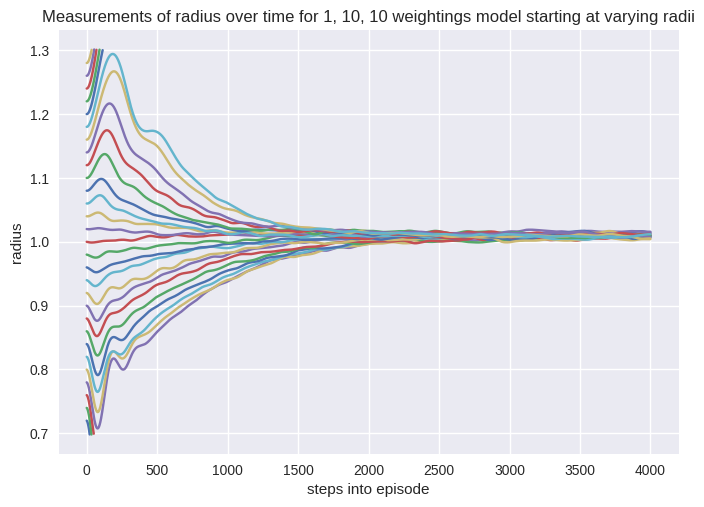

1.28-- 35

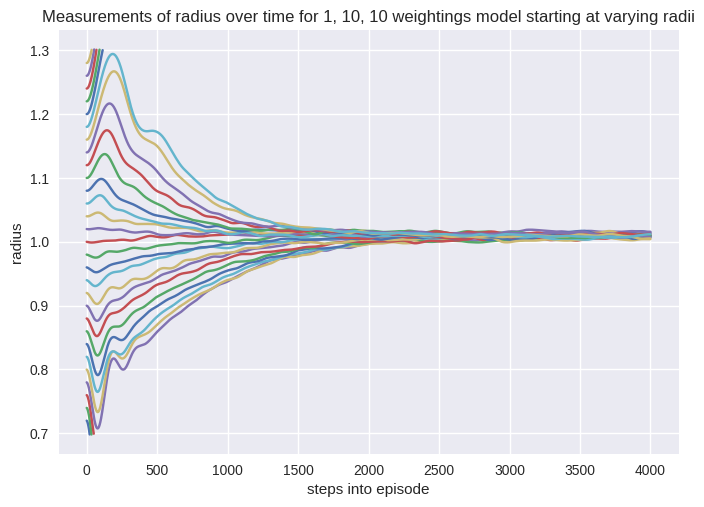

In [ ]:
def orbit1_1(r) -> Callable[[], List[np.float32]]:
  def func():
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1 / np.sqrt(r)
    pos = [r, 0]
    vel = [rdot, r * thetadot]
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

rs_list = []
actions_list = []
labels = [round(r, 3) for r in np.arange(0.72, 1.28, 0.02)]
for r in labels:
  init_func = orbit1_1(r)
  env = RocketEnv(max_step=25_000, simulation_step=1, rmax=1.3, rmin=0.7,
              w_r = 10 , w_p = 10, w_t = 1,
              mode = "Ln", init_func=init_func,
              max_thrust=1, oob_penalty=0, dt=0.01)
  env = PolarizeObservation(env)
  env = CTangentialThrust(env)

  state = env.reset()
  done = False
  i = 0
  r_list = []
  action_list = []
  while not done:
      print(f"\r{r}-- {i}", end="")
      env.render()
      action = ppo_agent.select_action(state, 1, -1)
      state, reward, done, _ = env.step(action)
      r_list.append(state[0])
      action_list.append(action)
      i += 1
      done = done or i == 4_000
  rs_list.append(r_list)
  actions_list.append(action_list)

for i in range(len(rs_list)):
    plt.plot(np.arange(len(rs_list[i])), rs_list[i])
plt.title("Measurements of radius over time for 1, 10, 10 weightings model starting at varying radii")
plt.ylabel("radius")
plt.xlabel("steps into episode")
plt.show()

#### $r=0.8$ (faster velocity) $\Rightarrow 1$

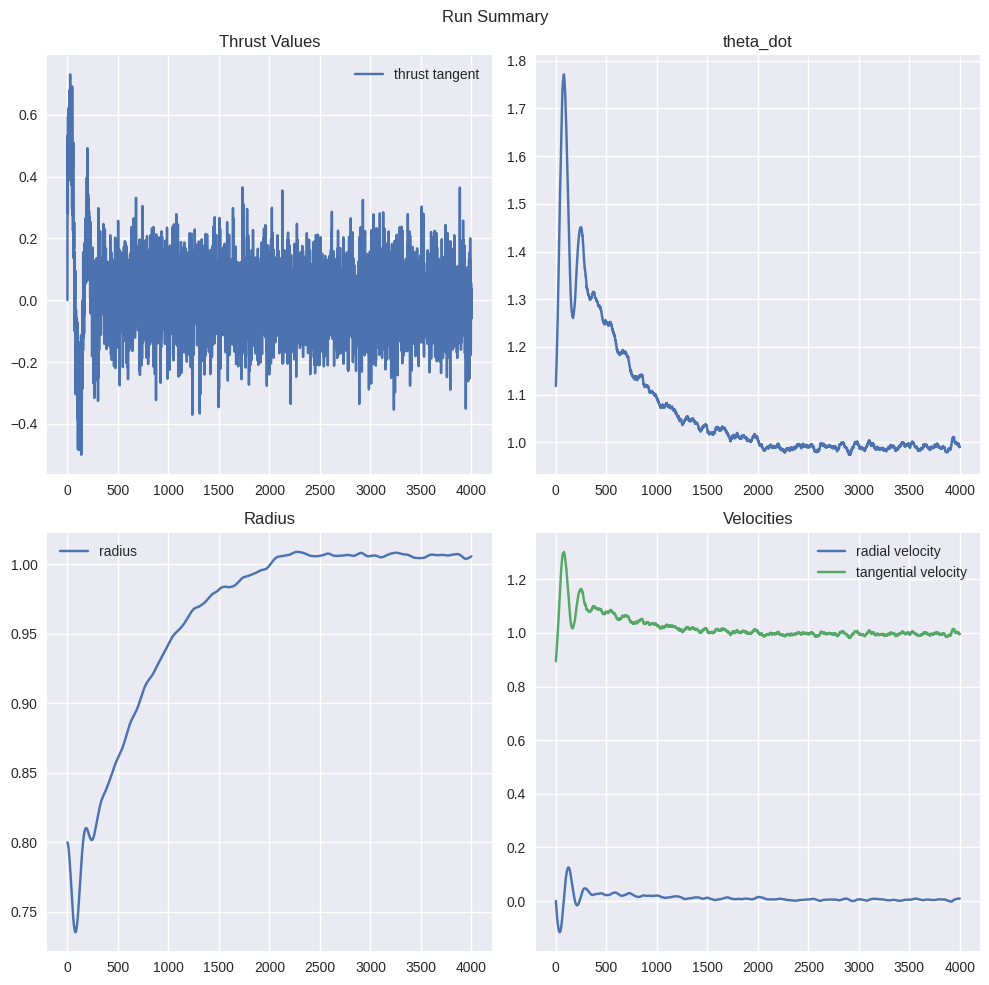

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:89: DeprecationWarning: invalid escape sequence '\h'
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.s

4000
It is creating a figure 1 


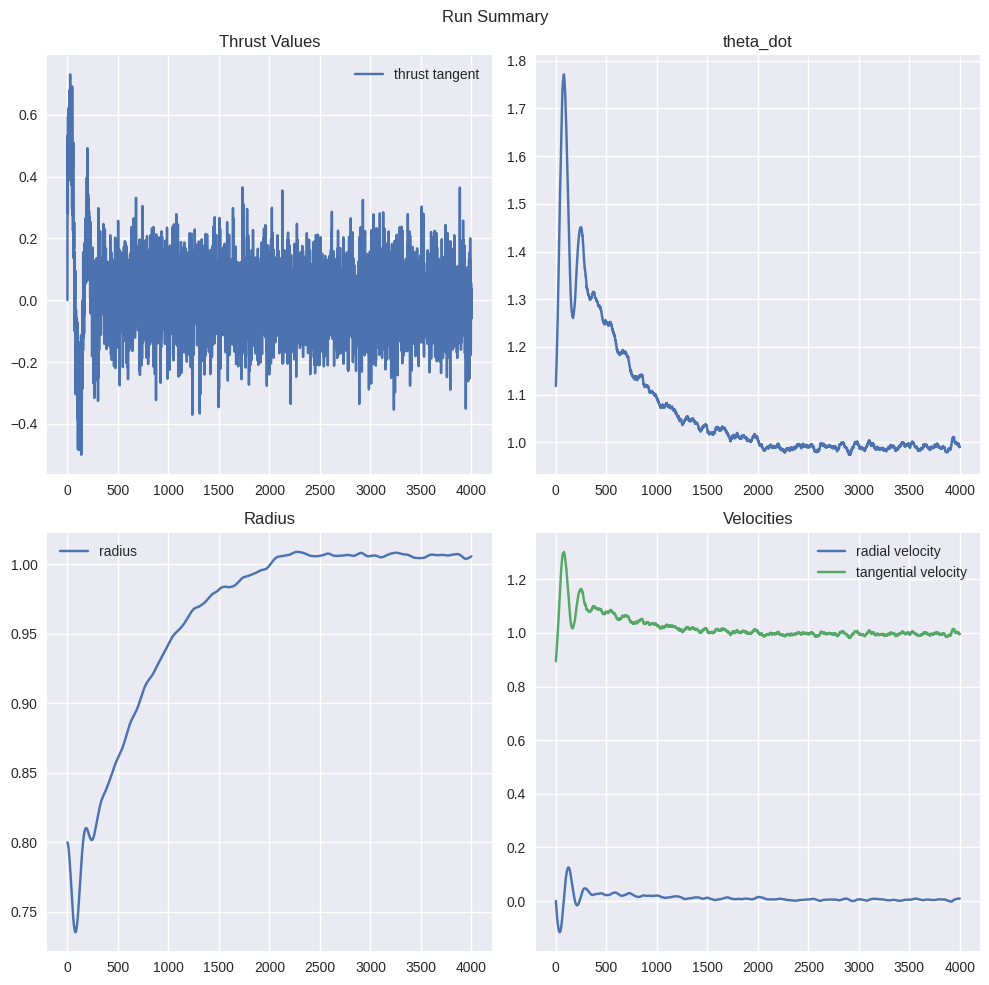

In [ ]:
class RocketAnimation(object):
    def __init__(self, r_min=0.1, r_target=1, r_max=10, xlim=(-10.2, 10.2), ylim=(-10.2, 10.2), markersize=10, circle_alpha=1, t_vec_len=1):
        self.r_min = r_min
        self.r_target = r_target
        self.r_max = r_max

        self.marker_size = markersize
        self.circle_alpha = circle_alpha1
        self.t_vec_len = t_vec_len

        self.states = list()
        self.thrusts = list()
        # Note : I am not using requested_thrust for now, but I let it because I think it could be interesting
        self.requested_thrusts = list()
        self.theta_dot = list()

        #plots to verify the behavior of the actor critic
        self.rewards = list()
        self.action = list()

        # Wait why on earth is that a list ??
        self.rmin = list()
        self.rtarget = list()
        self.rmax = list()

        self.xlim = xlim
        self.ylim = ylim


    #No changes are made to this function
    def _circle(self, radius):
        theta = np.linspace(0, 2 * np.pi, 100)
        x, y = radius * np.cos(theta), radius * np.sin(theta)
        return x, y

    def _init(self,):
        self.ax.clear()

        self.arrow = Arrow(posA=(0, 0), posB=(0, 0), arrowstyle='simple', mutation_scale=5, color='r')
        self.ax.add_patch(self.arrow)
        self.line, = self.ax.plot([], [], marker='o', markersize=self.marker_size, alpha=self.circle_alpha)
        self.min_circle, = self.ax.plot(*self._circle(self.r_min), '--', label='Minimum Radius')
        self.start_circle, = self.ax.plot(*self._circle(0.8), '--', label='Starting Orbit', color='tab:orange') ##### TARGET = 1.1
        self.target_circle, = self.ax.plot(*self._circle(self.r_target), '--', label='Target Orbit')
        self.max_circle, = self.ax.plot(*self._circle(self.r_max), '--', label='Maximum Radius')
        self.ax.grid(True)
        self.ax.legend(loc='upper left')
        return self.line, self.min_circle, self.target_circle, self.max_circle


    def _animate(self, i):
        st = self.states[i]
        vec = self.thrusts[i] * self.t_vec_len * (self.xlim[1] - self.xlim[0])

        self.line.set_data([st[0]], [st[1]])
        self.min_circle.set_data(*self._circle(self.rmin[i]))
        self.target_circle.set_data(*self._circle(self.rtarget[i]))
        self.max_circle.set_data(*self._circle(self.rmax[i]))

        self.arrow.set_positions(posA=st[:2], posB=st[:2] + vec)
        self.fig.suptitle(f'Iteration: {i}')
        return self.line, self.min_circle, self.target_circle, self.max_circle

    def save_animation(self, name):
        self._transform_vectors()
        self.fig = plt.figure(figsize=(10, 10), num=1,
                              clear=True, tight_layout=True)
        self.ax = self.fig.add_subplot(111)
        anim = FuncAnimation(self.fig, self._animate, init_func=self._init, frames=len(
            self.states), blit=True, interval=100, repeat=False)
        anim.save(name, dpi=80)

    def _plot_thrust_magnitude(self, ax):
        ax.set_title('Thrust Magnitude')
        ax.plot(self.thrusts_norm, label='thrust magnitude')
        ax.plot(self.requested_thrusts_norm,
                    label='requested thrust magnitude')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_value(self, ax):
        ax.set_title('Thrust Values')
        ax.plot([thrust[1]
                     for thrust in self.thrusts_polar], label='thrust tangent')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_direction(self, ax):
        ax.set_title('Thrust Direction (Angle from $\hat{r}$)')
        ax.plot(self.thrust_direction, label='Thrust Direction')
        ax.plot(self.requested_thrust_direction,
                label='Requested Thrust Direction')
        ax.grid(True)
        ax.legend()

    def _plot_radius(self, ax):
        ax.set_title('Radius')
        ax.plot(self.rs, label='radius')
        ax.grid(True)
        ax.legend()

    def _plot_velocities(self, ax):
        ax.set_title('Velocities')
        ax.plot([vel[0] for vel in self.vel_polar], label='radial velocity')
        ax.plot([vel[1] for vel in self.vel_polar],
                label='tangential velocity')
        ax.grid(True)
        ax.legend()

    def _plot_theta_dot(self, ax):
      ax.set_title('theta_dot')
      ax.plot([theta for theta in self.theta_dot])
      ax.grid(True)

    def summary_plot(self):
        self._transform_vectors()
        print("It is creating a figure 1 ")
        self.fig1 = plt.figure(figsize=(10, 5), num=1,
                              clear=True, tight_layout=True)
        ax1 = self.fig1.add_subplot(221)
        ax2 = self.fig1.add_subplot(222)
        ax3 = self.fig1.add_subplot(223)
        ax4 = self.fig1.add_subplot(224)

        self.fig1.suptitle('Run Summary')


        self._plot_thrust_value(ax1)
        self._plot_theta_dot(ax2)
        self._plot_radius(ax3)
        self._plot_velocities(ax4)

        self.fig1.tight_layout()

        return self.fig1

    def show(self, name):
      self.save_animation(name)
      self.summary_plot()


    def _get_transforms(self, states):
        transforms = list()
        rs = list()
        thetas = list()

        for st in states:
            pos, vel = st[:2], st[2:]
            r = np.linalg.norm(pos)
            theta = np.arctan2(pos[1], pos[0])
            rhat = pos / r

            rot_mat = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
            transforms.append(rot_mat)
            rs.append(r)
            thetas.append(theta)

        return transforms, rs, thetas

    def _forward_transform(self, transforms, vecs):
        return [tr @ vec for tr, vec in zip(transforms, vecs)]

    def _inverse_transform(self, transforms, vecs):
        return [tr.T @ vec for tr, vec in zip(transforms, vecs)]


    def _transform_vectors(self, ):
        transforms, self.rs, self.thetas = self._get_transforms(self.states)
        self.vel_polar = self._inverse_transform(
            transforms, [st[2:] for st in self.states])
        self.thrusts_polar = self._inverse_transform(transforms, self.thrusts)
        self.requested_thrusts_polar = self._inverse_transform(
            transforms, self.requested_thrusts)
        self.theta_dot = [v_tangential / r if r != 0 else 0 for v_tangential, r in zip([vel[1] for vel in self.vel_polar], self.rs)]
        self.thrusts_norm = [np.linalg.norm(thrust) for thrust in self.thrusts]
        self.requested_thrusts_norm = [np.linalg.norm(
            thrust) for thrust in self.requested_thrusts]
        self.thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.thrusts_polar]
        self.requested_thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.requested_thrusts_polar]

    def render(self, state, thrust, requested_thrust, rmin, rtarget, rmax):
        self.states.append(state)
        self.thrusts.append(thrust)
        self.requested_thrusts.append(requested_thrust)
        self.rmin.append(rmin)
        self.rtarget.append(rtarget)
        self.rmax.append(rmax)

    def return_arrays(self):
      return self.states, self.thrusts

def custom_orbit() -> Callable[[], List[np.float32]]:
  def func():
    r = 0.8
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1 / np.sqrt(r)
    pos = [r, 0]
    vel = [rdot, r * thetadot]
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

############## TRAINING MODEL CHANGES####################
gamma = 0.9996
lr_actor = 1e-3
lr_critic = 2e-3
rmin = 0.8
rmax = 1.2
mode = "Ln"
w_t = 1
w_r = 10
w_p = 10
num = "1"
max_ep_len = 25_000
max_training_timesteps = 10_000_000
init_func = custom_orbit()


####### initialize environment hyperparameters ######
env = RocketEnv(max_step=25_000, simulation_step=1, rmax=1.3, rmin=0.7,
            w_r = w_r , w_p = w_p, w_t = w_t,
            mode = mode, init_func=init_func,
            max_thrust=1, oob_penalty=0, dt=0.01)
env = PolarizeObservation(env)
env = CTangentialThrust(env)
env_name = "Rocket Env"
has_continuous_action_space = True  # continuous action space; else discrete

print_freq = max_ep_len * 4         # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 5           # log avg reward in the interval (in num timesteps)
save_model_freq = max_ep_len * 10   # save model frequency (in num timesteps)

action_std = 0.1                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = print_freq * 3 # action_std decay frequency (in num timesteps)


################ PPO hyperparameters ################
update_timestep = max_ep_len        # update policy every 2 timesteps
K_epochs = 80                       # update policy for K epochs in one PPO update
eps_clip = 0.2                      # clip parameter for PPO
#####################################################

rmax = 1.5
vmax = 10
high = np.array([rmax,rmax,vmax,vmax], dtype=np.float32)

env.observation_space = spaces.Box(-high, high, dtype=np.float32)
env._max_episode_steps = max_ep_len
env.seed()

state_dim = 3  # state space dimension
action_dim = 1 # action space dimension

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.load("/content/general_navtor1.pth")
state = env.reset()
done = False
i = 0
while not done:
    env.render()
    action = ppo_agent.select_action(state, 1, -1)
    state, reward, done, _ = env.step(action)
    i += 1
    done = done or i == 4_000

print(i)
env.show(path='test.mp4')
show_video('test.mp4')

#### $r=1.2$ (slower velocity) $\Rightarrow 1$

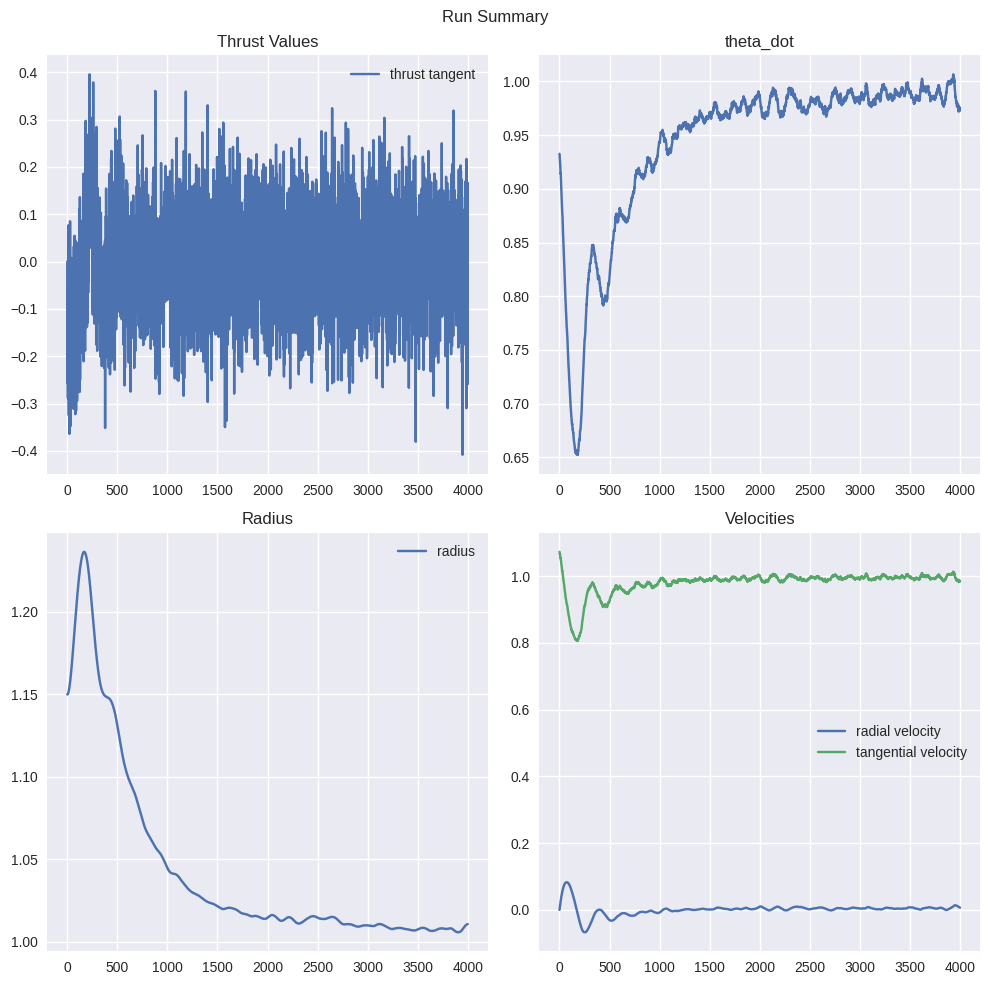

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:89: DeprecationWarning: invalid escape sequence '\h'
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.s

4000
It is creating a figure 1 


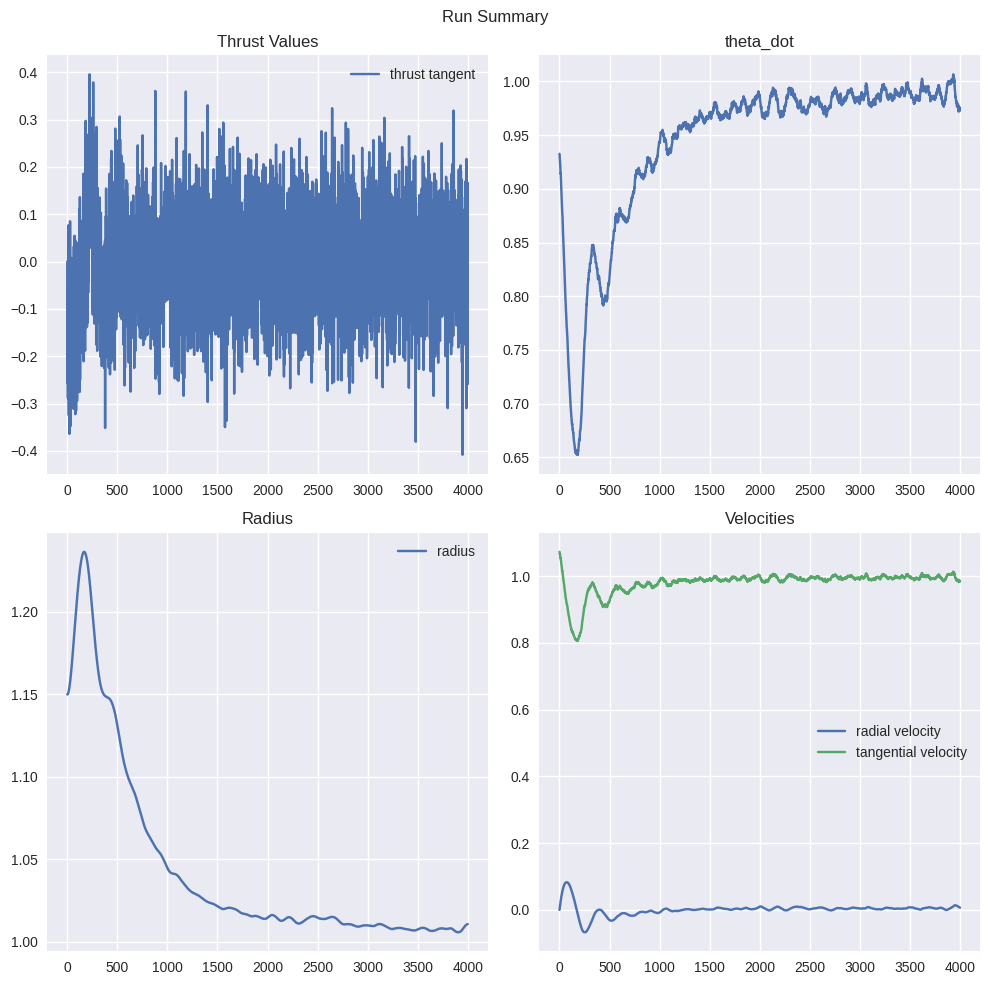

In [ ]:
class RocketAnimation(object):
    def __init__(self, r_min=0.1, r_target=1, r_max=10, xlim=(-10.2, 10.2), ylim=(-10.2, 10.2), markersize=10, circle_alpha=1, t_vec_len=1):
        self.r_min = r_min
        self.r_target = r_target
        self.r_max = r_max

        self.marker_size = markersize
        self.circle_alpha = circle_alpha
        self.t_vec_len = t_vec_len

        self.states = list()
        self.thrusts = list()
        # Note : I am not using requested_thrust for now, but I let it because I think it could be interesting
        self.requested_thrusts = list()
        self.theta_dot = list()

        #plots to verify the behavior of the actor critic
        self.rewards = list()
        self.action = list()

        # Wait why on earth is that a list ??
        self.rmin = list()
        self.rtarget = list()
        self.rmax = list()

        self.xlim = xlim
        self.ylim = ylim


    #No changes are made to this function
    def _circle(self, radius):
        theta = np.linspace(0, 2 * np.pi, 100)
        x, y = radius * np.cos(theta), radius * np.sin(theta)
        return x, y

    def _init(self,):
        self.ax.clear()

        self.arrow = Arrow(posA=(0, 0), posB=(0, 0), arrowstyle='simple', mutation_scale=5, color='r')
        self.ax.add_patch(self.arrow)
        self.line, = self.ax.plot([], [], marker='o', markersize=self.marker_size, alpha=self.circle_alpha)
        self.min_circle, = self.ax.plot(*self._circle(self.r_min), '--', label='Minimum Radius')
        self.start_circle, = self.ax.plot(*self._circle(1.15), '--', label='Starting Orbit', color='tab:orange') ##### TARGET = 1.2
        self.target_circle, = self.ax.plot(*self._circle(self.r_target), '--', label='Target Orbit')
        self.max_circle, = self.ax.plot(*self._circle(self.r_max), '--', label='Maximum Radius')
        self.ax.grid(True)
        self.ax.legend(loc='upper left')
        return self.line, self.min_circle, self.target_circle, self.max_circle


    def _animate(self, i):
        st = self.states[i]
        vec = self.thrusts[i] * self.t_vec_len * (self.xlim[1] - self.xlim[0])

        self.line.set_data([st[0]], [st[1]])
        self.min_circle.set_data(*self._circle(self.rmin[i]))
        self.target_circle.set_data(*self._circle(self.rtarget[i]))
        self.max_circle.set_data(*self._circle(self.rmax[i]))

        self.arrow.set_positions(posA=st[:2], posB=st[:2] + vec)
        self.fig.suptitle(f'Iteration: {i}')
        return self.line, self.min_circle, self.target_circle, self.max_circle

    def save_animation(self, name):
        self._transform_vectors()
        self.fig = plt.figure(figsize=(10, 10), num=1,
                              clear=True, tight_layout=True)
        self.ax = self.fig.add_subplot(111)
        anim = FuncAnimation(self.fig, self._animate, init_func=self._init, frames=len(
            self.states), blit=True, interval=100, repeat=False)
        anim.save(name, dpi=80)

    def _plot_thrust_magnitude(self, ax):
        ax.set_title('Thrust Magnitude')
        ax.plot(self.thrusts_norm, label='thrust magnitude')
        ax.plot(self.requested_thrusts_norm,
                    label='requested thrust magnitude')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_value(self, ax):
        ax.set_title('Thrust Values')
        ax.plot([thrust[1]
                     for thrust in self.thrusts_polar], label='thrust tangent')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_direction(self, ax):
        ax.set_title('Thrust Direction (Angle from $\hat{r}$)')
        ax.plot(self.thrust_direction, label='Thrust Direction')
        ax.plot(self.requested_thrust_direction,
                label='Requested Thrust Direction')
        ax.grid(True)
        ax.legend()

    def _plot_radius(self, ax):
        ax.set_title('Radius')
        ax.plot(self.rs, label='radius')
        ax.grid(True)
        ax.legend()

    def _plot_velocities(self, ax):
        ax.set_title('Velocities')
        ax.plot([vel[0] for vel in self.vel_polar], label='radial velocity')
        ax.plot([vel[1] for vel in self.vel_polar],
                label='tangential velocity')
        ax.grid(True)
        ax.legend()

    def _plot_theta_dot(self, ax):
      ax.set_title('theta_dot')
      ax.plot([theta for theta in self.theta_dot])
      ax.grid(True)

    def summary_plot(self):
        self._transform_vectors()
        print("It is creating a figure 1 ")
        self.fig1 = plt.figure(figsize=(10, 5), num=1,
                              clear=True, tight_layout=True)
        ax1 = self.fig1.add_subplot(221)
        ax2 = self.fig1.add_subplot(222)
        ax3 = self.fig1.add_subplot(223)
        ax4 = self.fig1.add_subplot(224)

        self.fig1.suptitle('Run Summary')


        self._plot_thrust_value(ax1)
        self._plot_theta_dot(ax2)
        self._plot_radius(ax3)
        self._plot_velocities(ax4)

        self.fig1.tight_layout()

        return self.fig1

    def show(self, name):
      self.save_animation(name)
      self.summary_plot()


    def _get_transforms(self, states):
        transforms = list()
        rs = list()
        thetas = list()

        for st in states:
            pos, vel = st[:2], st[2:]
            r = np.linalg.norm(pos)
            theta = np.arctan2(pos[1], pos[0])
            rhat = pos / r

            rot_mat = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
            transforms.append(rot_mat)
            rs.append(r)
            thetas.append(theta)

        return transforms, rs, thetas

    def _forward_transform(self, transforms, vecs):
        return [tr @ vec for tr, vec in zip(transforms, vecs)]

    def _inverse_transform(self, transforms, vecs):
        return [tr.T @ vec for tr, vec in zip(transforms, vecs)]


    def _transform_vectors(self, ):
        transforms, self.rs, self.thetas = self._get_transforms(self.states)
        self.vel_polar = self._inverse_transform(
            transforms, [st[2:] for st in self.states])
        self.thrusts_polar = self._inverse_transform(transforms, self.thrusts)
        self.requested_thrusts_polar = self._inverse_transform(
            transforms, self.requested_thrusts)
        self.theta_dot = [v_tangential / r if r != 0 else 0 for v_tangential, r in zip([vel[1] for vel in self.vel_polar], self.rs)]
        self.thrusts_norm = [np.linalg.norm(thrust) for thrust in self.thrusts]
        self.requested_thrusts_norm = [np.linalg.norm(
            thrust) for thrust in self.requested_thrusts]
        self.thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.thrusts_polar]
        self.requested_thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.requested_thrusts_polar]

    def render(self, state, thrust, requested_thrust, rmin, rtarget, rmax):
        self.states.append(state)
        self.thrusts.append(thrust)
        self.requested_thrusts.append(requested_thrust)
        self.rmin.append(rmin)
        self.rtarget.append(rtarget)
        self.rmax.append(rmax)

    def return_arrays(self):
      return self.states, self.thrusts

def custom_orbit() -> Callable[[], List[np.float32]]:
  def func():
    r = 1.15
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1 / np.sqrt(r)
    pos = [r, 0]
    vel = [rdot, r * thetadot]
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

############## TRAINING MODEL CHANGES####################
gamma = 0.9996
lr_actor = 1e-3
lr_critic = 2e-3
rmin = 0.7
rmax = 1.3
mode = "Ln"
w_t = 1
w_r = 10
w_p = 10
num = "1"
max_ep_len = 25_000
max_training_timesteps = 10_000_000
init_func = custom_orbit()


####### initialize environment hyperparameters ######
env = RocketEnv(max_step=25_000, simulation_step=1, rmax=1.3, rmin=0.7,
            w_r = w_r , w_p = w_p, w_t = w_t,
            mode = mode, init_func=init_func,
            max_thrust=1, oob_penalty=0, dt=0.01)
env = PolarizeObservation(env)
env = CTangentialThrust(env)
env_name = "Rocket Env"
has_continuous_action_space = True  # continuous action space; else discrete

print_freq = max_ep_len * 4         # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 5           # log avg reward in the interval (in num timesteps)
save_model_freq = max_ep_len * 10   # save model frequency (in num timesteps)

action_std = 0.1                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = print_freq * 3 # action_std decay frequency (in num timesteps)


################ PPO hyperparameters ################
update_timestep = max_ep_len        # update policy every 2 timesteps
K_epochs = 80                       # update policy for K epochs in one PPO update
eps_clip = 0.2                      # clip parameter for PPO
#####################################################

rmax = 1.5
vmax = 10
high = np.array([rmax,rmax,vmax,vmax], dtype=np.float32)

env.observation_space = spaces.Box(-high, high, dtype=np.float32)
env._max_episode_steps = max_ep_len
env.seed()

state_dim = 3  # state space dimension
action_dim = 1 # action space dimension

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.load("/content/general_navtor1.pth")
state = env.reset()
done = False
i = 0
while not done:
    env.render()
    action = ppo_agent.select_action(state, 1, -1)
    state, reward, done, _ = env.step(action)
    i += 1
    done = done or i == 4_000

print(i)
env.show(path='test.mp4')
show_video('test.mp4')

#### Training Curve

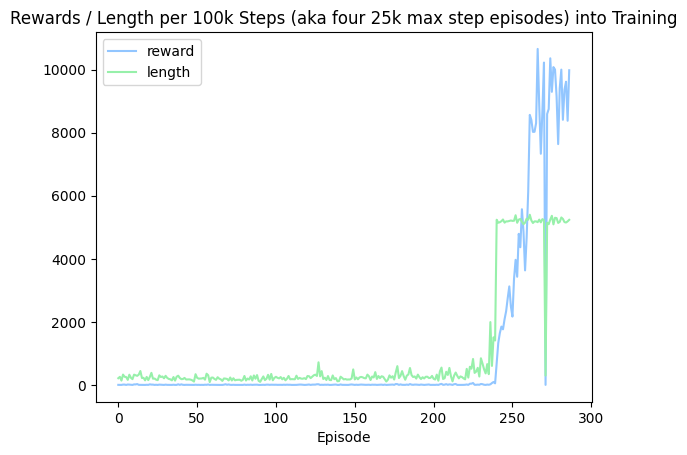

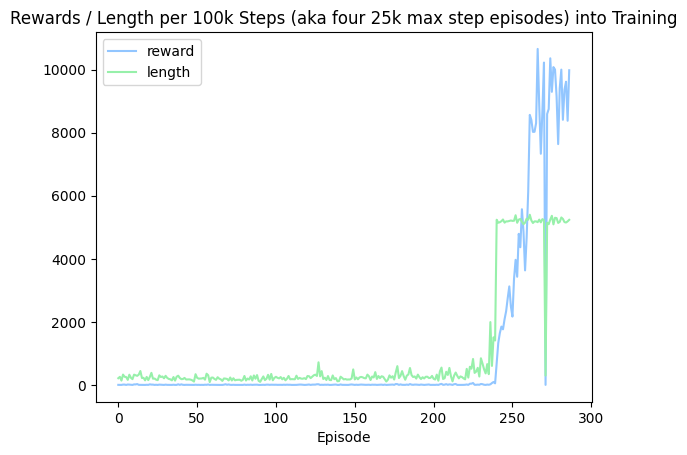

In [ ]:
avg_rewards = [2.3070841873845165, 0.10387705123645175, 0.2226250079231166, 10.878508072799733, 10.374979644532823, 0.0, 13.042594856479493, 9.960986639087656, 3.2211444191634535, 0.02686855575038729, 16.70898592653034, 15.757262701153369, 27.07678309690765, 2.5393694150262927, 1.3478419869300495, 0.18997645889752274, 0.10334396920502062, 0.10724288250889603, 4.538883246274868, 1.269857258375625, 18.688152655383654, 9.97692039799053, 9.975168034707334, 0.5677412518499706, 5.246047540592569, 0.0, 9.907545219791702, 7.228812930636597, 7.914662727512035, 0.042130499434033006, 9.091072415182309, 2.149797637335969, 0.35436109516303466, 1.1176940487501148, 0.6092732285127761, 6.322267315695315, 0.0, 0.8197667794072523, 19.838715753989355, 1.1477724269830623, 18.23317725492716, 3.3153439716666617, 0.0, 3.810583008158003, 3.309129392188706, 0.046917250822609995, 0.0, 0.1041162479195932, 0.647249829977826, 6.326305001634058, 1.6370733194673686, 3.1611537207208076, 0.10779198287311223, 2.2206740086674195, 0.005817706903512895, 6.3897227363759175, 3.304352118453486, 14.05812624369524, 0.0, 4.240289945414021, 3.0942548211669965, 0.3985805636760179, 4.302080857340042, 2.795368186998915, 0.25181032275622955, 1.1836855909221657, 0.05496077679454179, 7.844676932406849, 20.93335439307122, 4.492396291349462, 14.47886721659717, 2.976089177755349, 0.6076586016478064, 4.611800150917174, 0.784627774516198, 0.8384127395054284, 1.6490299376667967, 0.0, 0.4036210004351449, 0.5495416694034437, 9.942522965951618, 0.0, 5.596200926628343, 2.638565982732685, 8.07936409804621, 0.654360396751094, 5.5746985738940715, 6.293280126077521, 7.47687472964054, 0.10893871720767598, 0.0, 3.6555133019820176, 4.369808399571606, 1.0059622100877468, 8.512209855553914, 8.785952844093119, 2.409683720691224, 6.873926908744992, 5.205545157323684, 4.349184734356838, 5.865688049695388, 2.0775817171387088, 3.1606249325509417, 3.730766899692707, 1.4165659483330637, 6.879851711264063, 2.453702144108182, 7.834098756414251, 4.409317462102388, 5.468392956233602, 0.14922632370384598, 0.17480726968934793, 0.0, 1.4806803422882722, 6.314806280296375, 10.958933670066655, 10.431359769787727, 4.421223621665726, 0.3201417470923299, 1.5910985528629427, 8.958358071531682, 13.111897017158475, 0.09667400371505228, 8.980126003641459, 10.585328968480713, 10.012191307068697, 21.546709718789714, 21.15389963819239, 0.8047890867922611, 5.181568062920555, 2.152692328567663, 7.0406180545260435, 4.450847950163493, 8.909272383805375, 0.0, 0.17526876010224834, 5.536260058581577, 9.544760588770663, 11.772406999328284, 0.0, 0.018352212720034216, 15.303340490375705, 2.8565315845328305, 1.6613339227459127, 2.4566540521528366, 1.0013706796387616, 0.6619684104068487, 9.678899417509305, 14.879322572726528, 6.713303156776226, 0.5851433537575315, 6.992128387814704, 1.2843850363978884, 6.730107278618341, 11.537478989861771, 8.307387232084738, 3.0394628216112127, 2.1673203845455107, 4.0702849860257295, 5.965518755011723, 0.0, 7.9983920325793125, 5.511905441672943, 6.593337885202818, 0.7509942786396626, 3.9216351771594997, 4.574449057300633, 9.454353619307987, 0.0, 10.038401716123438, 0.0, 2.5921098288127062, 2.7193117304609586, 6.000329408632542, 11.700406380344585, 2.0733713569399774, 28.0819142735103, 25.253292558746796, 1.210239383532845, 17.46358455661625, 3.3990108212829013, 3.902214367669046, 1.545970890093718, 11.538212776556671, 0.6918873543877077, 27.948276114712666, 8.652514598632974, 3.0188322553368097, 10.518068350769129, 10.151269551260743, 4.410133907119251, 1.2737049372287925, 11.916113046814642, 4.438113294768974, 0.16173274088114004, 6.1022235290670075, 9.357921094211514, 13.93793552931459, 0.8965415724935277, 2.8030580599563835, 2.502568689233777, 0.8682163159597792, 6.657636070889339, 0.0, 20.41036293552839, 32.9015194597754, 3.0464805947726954, 8.359334543683442, 25.00816357782868, 3.3354391086100996, 17.97863638035584, 11.595467432407245, 0.0, 22.414412336205896, 29.081150492096366, 0.0, 0.15163900939018338, 3.4948339683428613, 1.3257051574986722, 1.5712373933749986, 4.7087042905668905, 13.915272563430758, 0.9571974982518856, 38.09050532961773, 39.267250201198685, 61.31975058121573, 3.4594310046947836, 4.3130628268282605, 9.80993714612712, 4.7191748959295685, 29.75482216085391, 23.19673334487298, 5.445008637854279, 0.4222552275850407, 11.230254050597651, 5.41801515621351, 18.65703334448519, 59.67431782795016, 93.4482194178895, 50.78718292776848, 696.0663162206024, 1330.4279352155536, 1643.5694055108534, 1850.330023597158, 1763.593744547733, 2083.663272139725, 2339.9255990019865, 2751.9970467295925, 3124.8057995755134, 2492.2736195488806, 2167.4937102669173, 3364.1096225198094, 3967.930443322577, 3431.241785771996, 4791.60073747827, 4367.42248648227, 5572.414014736804, 4874.357738545889, 3632.815184022353, 4665.716213701771, 6140.632785394137, 8564.118072436284, 8403.732443479228, 8025.993231803326, 8028.294615957083, 8302.278463178947, 10657.10102929651, 8858.277354727537, 7331.975848957444, 8696.881760755254, 10224.274374881623, 1.2100416872931432, 8592.51417155867, 8751.978100202386, 10359.033552163872, 9296.056583264915, 10080.671787101583, 10002.261389367126, 9144.128382200231, 7638.333348559505, 9414.833315128337, 10000.561299322413, 8409.442582355465, 9366.673172195213, 9616.002790408047, 8378.092980982652, 9979.923302476242]
plt.xlabel("Episode")
plt.title("Rewards / Length per 100k Steps (aka four 25k max step episodes) into Training")
plt.plot(np.arange(len(avg_rewards)), avg_rewards, label="reward")

avg_lengths = [213, 255.8, 138, 328, 257.4, 250.6, 160.4, 324, 227.2, 183.6, 325.4, 306.8, 287.8, 327.6, 440.8, 219.8, 224.8, 145.2, 253.6, 152.8, 253.4, 382.8, 197.6, 202.6, 166.6, 151.8, 303.8, 251, 266.8, 209, 288.6, 224, 190.6, 177.8, 143.8, 249.8, 136.8, 259.4, 292.6, 220, 183.2, 187.6, 222.2, 171.8, 172.6, 176.4, 165.8, 143.4, 106.6, 339.6, 225.6, 199, 201.2, 205.2, 223, 167, 355.6, 307.2, 90.8, 230, 233.8, 189, 161.4, 244.6, 199.2, 176.6, 127.2, 204.8, 200.2, 188.6, 141.2, 235.2, 141.2, 211.8, 147.2, 159.8, 164, 165.2, 132.6, 160.4, 284, 140, 201.8, 170.8, 273.6, 140.6, 300, 196.8, 311.8, 130.2, 97.6, 188, 269.2, 152, 195, 320.4, 166.8, 348.8, 147.4, 222.4, 257.6, 224.4, 208.2, 249.4, 177.8, 226.4, 145.6, 197.6, 283.6, 178.8, 183.4, 182, 179.4, 292.2, 190.4, 223.2, 199.8, 196, 215.6, 184.6, 282.4, 275, 216.4, 263.6, 306, 324.8, 284.2, 717, 272, 438.2, 188.2, 228.8, 155.8, 281, 156.6, 151.6, 300.4, 181.2, 217, 116.4, 123.2, 260.2, 221.8, 175.8, 187, 169.6, 173.2, 172.6, 207.2, 491.4, 174.6, 237, 178.6, 237.6, 253.6, 240.8, 214.8, 209, 326.4, 274.6, 154.8, 267, 236.6, 405.8, 190.2, 281.8, 215.8, 275, 258, 182, 107.6, 166.4, 302.2, 229.2, 275.6, 171, 399.4, 596.2, 218.8, 287.4, 438, 281, 164.8, 293.4, 332.2, 536.4, 312.8, 251.4, 268.2, 201.4, 326.8, 244.8, 187.4, 243.6, 205.4, 258.4, 260.4, 219.4, 223.8, 285.8, 194.4, 171, 326.8, 133.2, 432.2, 549.4, 188.6, 213.4, 416.4, 316.6, 539.2, 273.8, 114.2, 295, 392.8, 289.2, 208.2, 269.8, 249.2, 206, 177.8, 508.8, 232.4, 576.2, 514.6, 822.2, 381.2, 423.2, 542.4, 266.6, 845.8, 678.4, 497.6, 365.4, 659.8, 342, 1992.4, 602.6, 1510, 1408.8, 5239.2, 5145.2, 5160.8, 5192.8, 5246.8, 5146.8, 5187, 5186.4, 5201.8, 5214.6, 5202.4, 5207.4, 5381.6, 5143.4, 5243.6, 5263.4, 5183.6, 5098, 5144.8, 5273.8, 5239.4, 5397.6, 5218, 5135.4, 5187, 5187, 5162.8, 5242.6, 5156.2, 5258.6, 5226.8, 297.6, 5143.4, 5098.4, 5245.4, 5363.8, 5092.4, 5301.4, 5291.6, 5137.4, 5171.6, 5311.2, 5265, 5164, 5151, 5187.4, 5236]
plt.plot(np.arange(len(avg_lengths)), avg_lengths, label="length")
plt.legend()
plt.show()

### W = {5 thrust, 10 radius, 15 momentum}



#### Tracking adjustment over radiial range

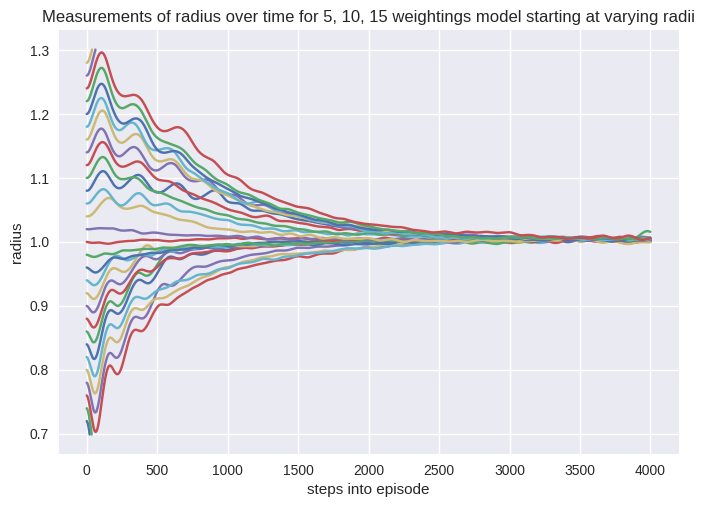

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


1.28-- 37

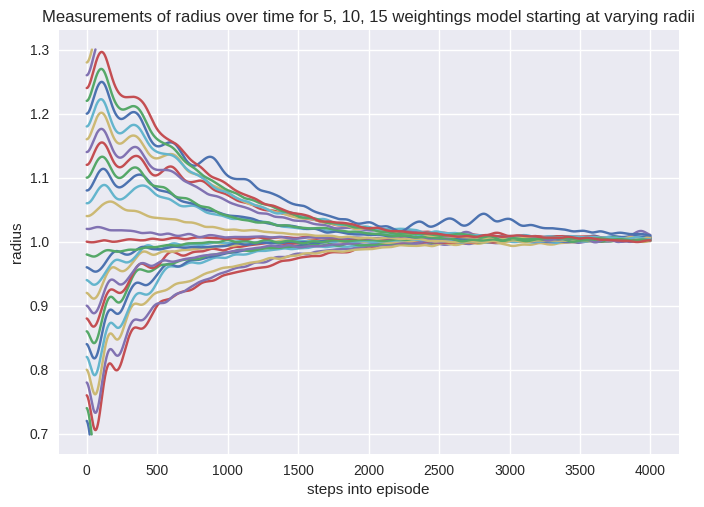

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


1.28-- 38

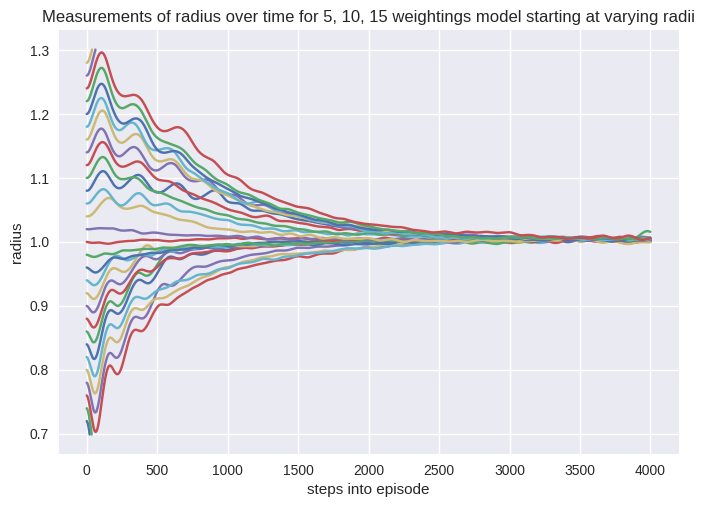

In [ ]:
def orbit1_1(r) -> Callable[[], List[np.float32]]:
  def func():
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1 / np.sqrt(r)
    pos = [r, 0]
    vel = [rdot, r * thetadot]
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

rs_list = []
actions_list = []
labels = [round(r, 3) for r in np.arange(0.72, 1.28, 0.02)]
for r in labels:
  init_func = orbit1_1(r)
  env = RocketEnv(max_step=25_000, simulation_step=1, rmax=1.3, rmin=0.7,
              w_r = 10 , w_p = 10, w_t = 1,
              mode = "Ln", init_func=init_func,
              max_thrust=1, oob_penalty=0, dt=0.01)
  env = PolarizeObservation(env)
  env = CTangentialThrust(env)

  state = env.reset()
  done = False
  i = 0
  r_list = []
  action_list = []
  while not done:
      print(f"\r{r}-- {i}", end="")
      env.render()
      action = ppo_agent.select_action(state, 1, -1)
      state, reward, done, _ = env.step(action)
      r_list.append(state[0])
      action_list.append(action)
      i += 1
      done = done or i == 4_000
  rs_list.append(r_list)
  actions_list.append(action_list)

for i in range(len(rs_list)):
    plt.plot(np.arange(len(rs_list[i])), rs_list[i])
plt.title("Measurements of radius over time for 5, 10, 15 weightings model starting at varying radii")
plt.ylabel("radius")
plt.xlabel("steps into episode")
plt.show()

#### $r=0.8$ (faster velocity) $\Rightarrow 1$

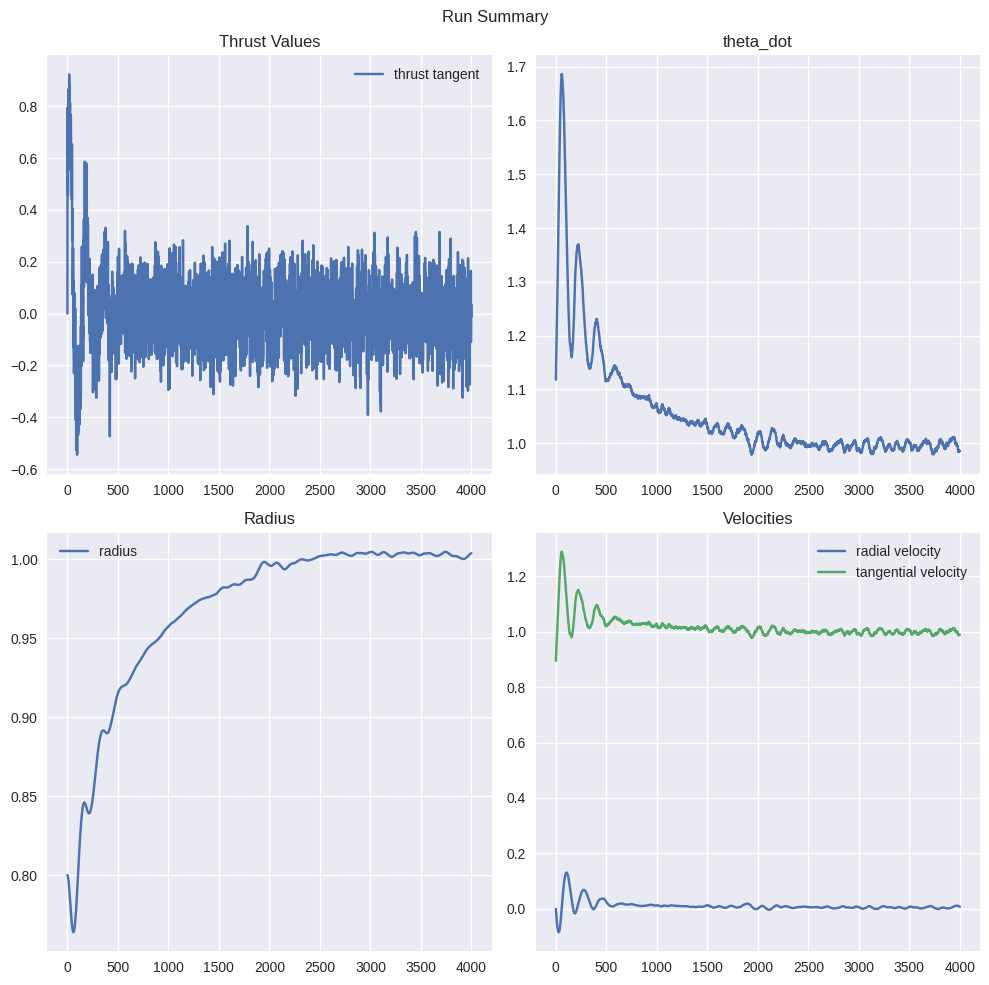

In [ ]:
class RocketAnimation(object):
    def __init__(self, r_min=0.1, r_target=1, r_max=10, xlim=(-10.2, 10.2), ylim=(-10.2, 10.2), markersize=10, circle_alpha=1, t_vec_len=1):
        self.r_min = r_min
        self.r_target = r_target
        self.r_max = r_max

        self.marker_size = markersize
        self.circle_alpha = circle_alpha
        self.t_vec_len = t_vec_len

        self.states = list()
        self.thrusts = list()
        # Note : I am not using requested_thrust for now, but I let it because I think it could be interesting
        self.requested_thrusts = list()
        self.theta_dot = list()

        #plots to verify the behavior of the actor critic
        self.rewards = list()
        self.action = list()

        # Wait why on earth is that a list ??
        self.rmin = list()
        self.rtarget = list()
        self.rmax = list()

        self.xlim = xlim
        self.ylim = ylim


    #No changes are made to this function
    def _circle(self, radius):
        theta = np.linspace(0, 2 * np.pi, 100)
        x, y = radius * np.cos(theta), radius * np.sin(theta)
        return x, y

    def _init(self,):
        self.ax.clear()

        self.arrow = Arrow(posA=(0, 0), posB=(0, 0), arrowstyle='simple', mutation_scale=5, color='r')
        self.ax.add_patch(self.arrow)
        self.line, = self.ax.plot([], [], marker='o', markersize=self.marker_size, alpha=self.circle_alpha)
        self.min_circle, = self.ax.plot(*self._circle(self.r_min), '--', label='Minimum Radius')
        self.start_circle, = self.ax.plot(*self._circle(0.8), '--', label='Starting Orbit', color='tab:orange') ##### TARGET = 1.1
        self.target_circle, = self.ax.plot(*self._circle(self.r_target), '--', label='Target Orbit')
        self.max_circle, = self.ax.plot(*self._circle(self.r_max), '--', label='Maximum Radius')
        self.ax.grid(True)
        self.ax.legend(loc='upper left')
        return self.line, self.min_circle, self.target_circle, self.max_circle


    def _animate(self, i):
        st = self.states[i]
        vec = self.thrusts[i] * self.t_vec_len * (self.xlim[1] - self.xlim[0])

        self.line.set_data([st[0]], [st[1]])
        self.min_circle.set_data(*self._circle(self.rmin[i]))
        self.target_circle.set_data(*self._circle(self.rtarget[i]))
        self.max_circle.set_data(*self._circle(self.rmax[i]))

        self.arrow.set_positions(posA=st[:2], posB=st[:2] + vec)
        self.fig.suptitle(f'Iteration: {i}')
        return self.line, self.min_circle, self.target_circle, self.max_circle

    def save_animation(self, name):
        self._transform_vectors()
        self.fig = plt.figure(figsize=(10, 10), num=1,
                              clear=True, tight_layout=True)
        self.ax = self.fig.add_subplot(111)
        anim = FuncAnimation(self.fig, self._animate, init_func=self._init, frames=len(
            self.states), blit=True, interval=100, repeat=False)
        anim.save(name, dpi=80)

    def _plot_thrust_magnitude(self, ax):
        ax.set_title('Thrust Magnitude')
        ax.plot(self.thrusts_norm, label='thrust magnitude')
        ax.plot(self.requested_thrusts_norm,
                    label='requested thrust magnitude')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_value(self, ax):
        ax.set_title('Thrust Values')
        ax.plot([thrust[1]
                     for thrust in self.thrusts_polar], label='thrust tangent')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_direction(self, ax):
        ax.set_title('Thrust Direction (Angle from $\hat{r}$)')
        ax.plot(self.thrust_direction, label='Thrust Direction')
        ax.plot(self.requested_thrust_direction,
                label='Requested Thrust Direction')
        ax.grid(True)
        ax.legend()

    def _plot_radius(self, ax):
        ax.set_title('Radius')
        ax.plot(self.rs, label='radius')
        ax.grid(True)
        ax.legend()

    def _plot_velocities(self, ax):
        ax.set_title('Velocities')
        ax.plot([vel[0] for vel in self.vel_polar], label='radial velocity')
        ax.plot([vel[1] for vel in self.vel_polar],
                label='tangential velocity')
        ax.grid(True)
        ax.legend()

    def _plot_theta_dot(self, ax):
      ax.set_title('theta_dot')
      ax.plot([theta for theta in self.theta_dot])
      ax.grid(True)

    def summary_plot(self):
        self._transform_vectors()
        print("It is creating a figure 1 ")
        self.fig1 = plt.figure(figsize=(10, 5), num=1,
                              clear=True, tight_layout=True)
        ax1 = self.fig1.add_subplot(221)
        ax2 = self.fig1.add_subplot(222)
        ax3 = self.fig1.add_subplot(223)
        ax4 = self.fig1.add_subplot(224)

        self.fig1.suptitle('Run Summary')


        self._plot_thrust_value(ax1)
        self._plot_theta_dot(ax2)
        self._plot_radius(ax3)
        self._plot_velocities(ax4)

        self.fig1.tight_layout()

        return self.fig1

    def show(self, name):
      self.save_animation(name)
      self.summary_plot()


    def _get_transforms(self, states):
        transforms = list()
        rs = list()
        thetas = list()

        for st in states:
            pos, vel = st[:2], st[2:]
            r = np.linalg.norm(pos)
            theta = np.arctan2(pos[1], pos[0])
            rhat = pos / r

            rot_mat = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
            transforms.append(rot_mat)
            rs.append(r)
            thetas.append(theta)

        return transforms, rs, thetas

    def _forward_transform(self, transforms, vecs):
        return [tr @ vec for tr, vec in zip(transforms, vecs)]

    def _inverse_transform(self, transforms, vecs):
        return [tr.T @ vec for tr, vec in zip(transforms, vecs)]


    def _transform_vectors(self, ):
        transforms, self.rs, self.thetas = self._get_transforms(self.states)
        self.vel_polar = self._inverse_transform(
            transforms, [st[2:] for st in self.states])
        self.thrusts_polar = self._inverse_transform(transforms, self.thrusts)
        self.requested_thrusts_polar = self._inverse_transform(
            transforms, self.requested_thrusts)
        self.theta_dot = [v_tangential / r if r != 0 else 0 for v_tangential, r in zip([vel[1] for vel in self.vel_polar], self.rs)]
        self.thrusts_norm = [np.linalg.norm(thrust) for thrust in self.thrusts]
        self.requested_thrusts_norm = [np.linalg.norm(
            thrust) for thrust in self.requested_thrusts]
        self.thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.thrusts_polar]
        self.requested_thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.requested_thrusts_polar]

    def render(self, state, thrust, requested_thrust, rmin, rtarget, rmax):
        self.states.append(state)
        self.thrusts.append(thrust)
        self.requested_thrusts.append(requested_thrust)
        self.rmin.append(rmin)
        self.rtarget.append(rtarget)
        self.rmax.append(rmax)

    def return_arrays(self):
      return self.states, self.thrusts

def custom_orbit() -> Callable[[], List[np.float32]]:
  def func():
    r = 0.8
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1 / np.sqrt(r)
    pos = [r, 0]
    vel = [rdot, r * thetadot]
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

############## TRAINING MODEL CHANGES####################
gamma = 0.9996
lr_actor = 1e-3
lr_critic = 2e-3
rmin = 0.8
rmax = 1.2
mode = "Ln"
w_t = 1
w_r = 10
w_p = 10
num = "1"
max_ep_len = 25_000
max_training_timesteps = 10_000_000
init_func = custom_orbit()


####### initialize environment hyperparameters ######
env = RocketEnv(max_step=25_000, simulation_step=1, rmax=1.3, rmin=0.7,
            w_r = w_r , w_p = w_p, w_t = w_t,
            mode = mode, init_func=init_func,
            max_thrust=1, oob_penalty=0, dt=0.01)
env = PolarizeObservation(env)
env = CTangentialThrust(env)
env_name = "Rocket Env"
has_continuous_action_space = True  # continuous action space; else discrete

print_freq = max_ep_len * 4         # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 5           # log avg reward in the interval (in num timesteps)
save_model_freq = max_ep_len * 10   # save model frequency (in num timesteps)

action_std = 0.1                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = print_freq * 3 # action_std decay frequency (in num timesteps)


################ PPO hyperparameters ################
update_timestep = max_ep_len        # update policy every 2 timesteps
K_epochs = 80                       # update policy for K epochs in one PPO update
eps_clip = 0.2                      # clip parameter for PPO
#####################################################

rmax = 1.5
vmax = 10
high = np.array([rmax,rmax,vmax,vmax], dtype=np.float32)

env.observation_space = spaces.Box(-high, high, dtype=np.float32)
env._max_episode_steps = max_ep_len
env.seed()

state_dim = 3  # state space dimension
action_dim = 1 # action space dimension

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.load("/content/general_navtor1-2.pth")
state = env.reset()
done = False
i = 0
while not done:
    env.render()
    action = ppo_agent.select_action(state, 1, -1)
    state, reward, done, _ = env.step(action)
    i += 1
    done = done or i == 4_000

print(i)
env.show(path='test.mp4')
show_video('test.mp4')

Output hidden; open in https://colab.research.google.com to view.

#### $r=1.2$ (slower version) $\Rightarrow 1$

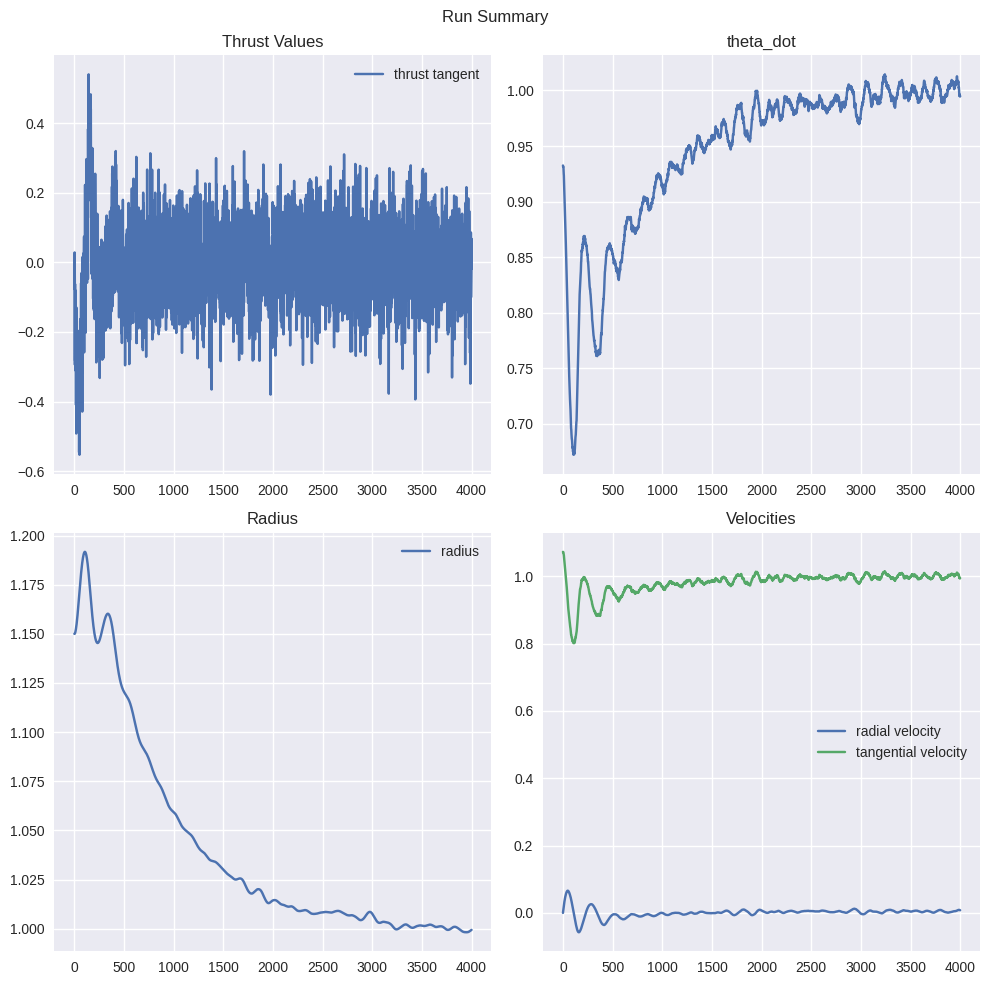

In [ ]:
class RocketAnimation(object):
    def __init__(self, r_min=0.1, r_target=1, r_max=10, xlim=(-10.2, 10.2), ylim=(-10.2, 10.2), markersize=10, circle_alpha=1, t_vec_len=1):
        self.r_min = r_min
        self.r_target = r_target
        self.r_max = r_max

        self.marker_size = markersize
        self.circle_alpha = circle_alpha
        self.t_vec_len = t_vec_len

        self.states = list()
        self.thrusts = list()
        # Note : I am not using requested_thrust for now, but I let it because I think it could be interesting
        self.requested_thrusts = list()
        self.theta_dot = list()

        #plots to verify the behavior of the actor critic
        self.rewards = list()
        self.action = list()

        # Wait why on earth is that a list ??
        self.rmin = list()
        self.rtarget = list()
        self.rmax = list()

        self.xlim = xlim
        self.ylim = ylim


    #No changes are made to this function
    def _circle(self, radius):
        theta = np.linspace(0, 2 * np.pi, 100)
        x, y = radius * np.cos(theta), radius * np.sin(theta)
        return x, y

    def _init(self,):
        self.ax.clear()

        self.arrow = Arrow(posA=(0, 0), posB=(0, 0), arrowstyle='simple', mutation_scale=5, color='r')
        self.ax.add_patch(self.arrow)
        self.line, = self.ax.plot([], [], marker='o', markersize=self.marker_size, alpha=self.circle_alpha)
        self.min_circle, = self.ax.plot(*self._circle(self.r_min), '--', label='Minimum Radius')
        self.start_circle, = self.ax.plot(*self._circle(1.15), '--', label='Starting Orbit', color='tab:orange') ##### TARGET = 1.2
        self.target_circle, = self.ax.plot(*self._circle(self.r_target), '--', label='Target Orbit')
        self.max_circle, = self.ax.plot(*self._circle(self.r_max), '--', label='Maximum Radius')
        self.ax.grid(True)
        self.ax.legend(loc='upper left')
        return self.line, self.min_circle, self.target_circle, self.max_circle


    def _animate(self, i):
        st = self.states[i]
        vec = self.thrusts[i] * self.t_vec_len * (self.xlim[1] - self.xlim[0])

        self.line.set_data([st[0]], [st[1]])
        self.min_circle.set_data(*self._circle(self.rmin[i]))
        self.target_circle.set_data(*self._circle(self.rtarget[i]))
        self.max_circle.set_data(*self._circle(self.rmax[i]))

        self.arrow.set_positions(posA=st[:2], posB=st[:2] + vec)
        self.fig.suptitle(f'Iteration: {i}')
        return self.line, self.min_circle, self.target_circle, self.max_circle

    def save_animation(self, name):
        self._transform_vectors()
        self.fig = plt.figure(figsize=(10, 10), num=1,
                              clear=True, tight_layout=True)
        self.ax = self.fig.add_subplot(111)
        anim = FuncAnimation(self.fig, self._animate, init_func=self._init, frames=len(
            self.states), blit=True, interval=100, repeat=False)
        anim.save(name, dpi=80)

    def _plot_thrust_magnitude(self, ax):
        ax.set_title('Thrust Magnitude')
        ax.plot(self.thrusts_norm, label='thrust magnitude')
        ax.plot(self.requested_thrusts_norm,
                    label='requested thrust magnitude')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_value(self, ax):
        ax.set_title('Thrust Values')
        ax.plot([thrust[1]
                     for thrust in self.thrusts_polar], label='thrust tangent')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_direction(self, ax):
        ax.set_title('Thrust Direction (Angle from $\hat{r}$)')
        ax.plot(self.thrust_direction, label='Thrust Direction')
        ax.plot(self.requested_thrust_direction,
                label='Requested Thrust Direction')
        ax.grid(True)
        ax.legend()

    def _plot_radius(self, ax):
        ax.set_title('Radius')
        ax.plot(self.rs, label='radius')
        ax.grid(True)
        ax.legend()

    def _plot_velocities(self, ax):
        ax.set_title('Velocities')
        ax.plot([vel[0] for vel in self.vel_polar], label='radial velocity')
        ax.plot([vel[1] for vel in self.vel_polar],
                label='tangential velocity')
        ax.grid(True)
        ax.legend()

    def _plot_theta_dot(self, ax):
      ax.set_title('theta_dot')
      ax.plot([theta for theta in self.theta_dot])
      ax.grid(True)

    def summary_plot(self):
        self._transform_vectors()
        print("It is creating a figure 1 ")
        self.fig1 = plt.figure(figsize=(10, 5), num=1,
                              clear=True, tight_layout=True)
        ax1 = self.fig1.add_subplot(221)
        ax2 = self.fig1.add_subplot(222)
        ax3 = self.fig1.add_subplot(223)
        ax4 = self.fig1.add_subplot(224)

        self.fig1.suptitle('Run Summary')


        self._plot_thrust_value(ax1)
        self._plot_theta_dot(ax2)
        self._plot_radius(ax3)
        self._plot_velocities(ax4)

        self.fig1.tight_layout()

        return self.fig1

    def show(self, name):
      self.save_animation(name)
      self.summary_plot()


    def _get_transforms(self, states):
        transforms = list()
        rs = list()
        thetas = list()

        for st in states:
            pos, vel = st[:2], st[2:]
            r = np.linalg.norm(pos)
            theta = np.arctan2(pos[1], pos[0])
            rhat = pos / r

            rot_mat = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
            transforms.append(rot_mat)
            rs.append(r)
            thetas.append(theta)

        return transforms, rs, thetas

    def _forward_transform(self, transforms, vecs):
        return [tr @ vec for tr, vec in zip(transforms, vecs)]

    def _inverse_transform(self, transforms, vecs):
        return [tr.T @ vec for tr, vec in zip(transforms, vecs)]


    def _transform_vectors(self, ):
        transforms, self.rs, self.thetas = self._get_transforms(self.states)
        self.vel_polar = self._inverse_transform(
            transforms, [st[2:] for st in self.states])
        self.thrusts_polar = self._inverse_transform(transforms, self.thrusts)
        self.requested_thrusts_polar = self._inverse_transform(
            transforms, self.requested_thrusts)
        self.theta_dot = [v_tangential / r if r != 0 else 0 for v_tangential, r in zip([vel[1] for vel in self.vel_polar], self.rs)]
        self.thrusts_norm = [np.linalg.norm(thrust) for thrust in self.thrusts]
        self.requested_thrusts_norm = [np.linalg.norm(
            thrust) for thrust in self.requested_thrusts]
        self.thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.thrusts_polar]
        self.requested_thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.requested_thrusts_polar]

    def render(self, state, thrust, requested_thrust, rmin, rtarget, rmax):
        self.states.append(state)
        self.thrusts.append(thrust)
        self.requested_thrusts.append(requested_thrust)
        self.rmin.append(rmin)
        self.rtarget.append(rtarget)
        self.rmax.append(rmax)

    def return_arrays(self):
      return self.states, self.thrusts

def custom_orbit() -> Callable[[], List[np.float32]]:
  def func():
    r = 1.15
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1 / np.sqrt(r)
    pos = [r, 0]
    vel = [rdot, r * thetadot]
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func

############## TRAINING MODEL CHANGES####################
gamma = 0.9996
lr_actor = 1e-3
lr_critic = 2e-3
rmin = 0.7
rmax = 1.3
mode = "Ln"
w_t = 5
w_r = 10
w_p = 15
num = "1"
max_ep_len = 25_000
max_training_timesteps = 10_000_000
init_func = custom_orbit()


####### initialize environment hyperparameters ######
env = RocketEnv(max_step=25_000, simulation_step=1, rmax=1.3, rmin=0.7,
            w_r = w_r , w_p = w_p, w_t = w_t,
            mode = mode, init_func=init_func,
            max_thrust=1, oob_penalty=0, dt=0.01)
env = PolarizeObservation(env)
env = CTangentialThrust(env)
env_name = "Rocket Env"
has_continuous_action_space = True  # continuous action space; else discrete

print_freq = max_ep_len * 4         # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 5           # log avg reward in the interval (in num timesteps)
save_model_freq = max_ep_len * 10   # save model frequency (in num timesteps)

action_std = 0.1                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = print_freq * 3 # action_std decay frequency (in num timesteps)


################ PPO hyperparameters ################
update_timestep = max_ep_len        # update policy every 2 timesteps
K_epochs = 80                       # update policy for K epochs in one PPO update
eps_clip = 0.2                      # clip parameter for PPO
#####################################################

rmax = 1.5
vmax = 10
high = np.array([rmax,rmax,vmax,vmax], dtype=np.float32)

env.observation_space = spaces.Box(-high, high, dtype=np.float32)
env._max_episode_steps = max_ep_len
env.seed()

state_dim = 3  # state space dimension
action_dim = 1 # action space dimension

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.load("/content/general_navtor1-2.pth")
state = env.reset()
done = False
i = 0
while not done:
    env.render()
    action = ppo_agent.select_action(state, 1, -1)
    state, reward, done, _ = env.step(action)
    i += 1
    done = done or i == 4_000

print(i)
env.show(path='test.mp4')
show_video('test.mp4')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Sample data
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
z = np.linspace(0, 10, 100)

data = np.zeros((len(x), len(y), len(z)))
for i, xi in enumerate(x):
    for j, yj in enumerate(y):
        for k, zk in enumerate(z):
            data[i, j, k] = model(xi, yj, zk)
data = np.sin(np.outer(x, y)[:, :, None] + z)

# Create the initial plot
fig = go.Figure()

# Adding the initial frame
fig.add_trace(go.Heatmap(z=data[:, :, 0], x=x, y=y, colorscale='Viridis'))

# Frames for each z-slice
frames = [go.Frame(data=[go.Heatmap(z=data[:, :, k], x=x, y=y, colorscale='Viridis')],
                   name=str(k)) for k in range(len(z))]

fig.update(frames=frames)

# Slider to scroll through the z-slices
sliders = [dict(steps=[dict(method='animate',
                            args=[[str(k)], dict(mode='immediate',
                                                 frame=dict(duration=100, redraw=True),
                                                 transition=dict(duration=0))],
                            label=str(k)) for k in range(len(z))],
                transition=dict(duration=0),
                x=0.1, y=0, currentvalue=dict(font=dict(size=20), prefix='Z-index: ', visible=True, xanchor='center'), len=0.9)]

fig.update_layout(updatemenus=[dict(type='buttons', showactive=False,
                                    buttons=[dict(label='Play',
                                                  method='animate',
                                                  args=[None, dict(frame=dict(duration=100, redraw=True),
                                                                   fromcurrent=True, mode='immediate')]),
                                             dict(label='Pause',
                                                  method='animate',
                                                  args=[[None], dict(frame=dict(duration=0, redraw=True),
                                                                     mode='immediate')])])],
                  sliders=sliders)

fig.show()

Output hidden; open in https://colab.research.google.com to view.